# Generative modeling in deep learning

Students: Raphaël Bernas and Maxime Corlay 

*This notebook consists of common introductory questions, followed by 4 different generative models (GAN, VAE, Flow matching, Diffusion flow), and a common conclusive question. **Choose & implement 2 among the 4 models**, not all of them! If you train more models, write down below the 2 ones you want to be graded on. Do not forget the last common question.*

> Please find below our answer for GANs & VAEs.

Generative modeling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modeling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modeling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

> Kullback Leibler Divergence : 
<br><br>
> $KL(p_\theta||p_D) = \int p_\theta log\left(\frac{p_\theta}{p_D}\right)$
<br><br>
> Optimal transport metric : (there are multiple way to denote it based on the transportation mass but we will use a compact notation from the cours)
<br><br>
> $OPT(p_\theta, p_D) = \sup_{F :\; 1-lipschitz}\left(\mathbb{E}_{X\sim p_\theta}[F(X)] - \mathbb{E}_{X\sim p_\theta}[F(X)]\right)$
<br><br>
> Mean decrepency metric : 
<br><br>
> We compute some statistics on the distribution (like its mean, variance, etc) $\mu_D, \mu_theta, \sigma_D, \sigma_\theta, m_D and m_\theta$. Then compare them
<br><br>
> $|| (\mu_D, \sigma_D, m_D)^T - (\mu_\theta, \sigma_\theta, m_\theta)^T ||^2$

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

> Those two kinds of methods efficiency vary a lot with the task given. But, some general observation we can make are the following :
<br><br>
> **Density based method :**
<br><br>
> - First, it is not always clear wether the density of our data can be easily simulated by a general known law (one from which we can sample easily). This force us to choose a prior on it which could often results in poor adapatation to the data distribution. This prior choice error is an irreducible error that we will need to keep in mind across the whole test as it could leads to an underperforming model.
<br><br>
> - Second, density comparison often rely on density parameters comparison (for density with known/explicit degrees of freedom). This could results in poorer spreading of the mass. Indeed, in some low probability region, the model could be uncapable to fit high variation which would results in a less specific law. This is what we observe with images generation, models often interpolate images generated between different classes by fusing them as if the in between values where present in the original distribution (which is not the case.)
<br><br>
> - Third, if we are to compare the probabilities, a lot of divergence method will sometime yields unstable results. That, is because low probabilities make logarithm based comparison explodes. In general there are risk, depending on the explicit comparison formula, that either small values or bigger one (near 1) results in unstable predicition (because it becomes too big or too small values for comparison).
<br><br>
> **Sampling based method :**
<br><br>
> - First, those methods are computationally much more expensive. Indeed, a closed form formula could be used in density based method (direct to compute), but here the more we sample and the more robust our approximation becomes. This induce high dependance on the number of sampling. And we do not know how the error induced by this evolves (it could reduces as much as explodes).
<br><br>
> - Second, the sampling process has a huge impact. There are indeed different kind of sampling process possbile. Some won't ever show low-likely data as a sample, thus making the model unable to perform prediction on those regions of the density.
<br><br>
> - Third, the optimization is highly dependant on other hyperparameters. Indeed, it is much lesser stable process because it needs proper definition of the problem. For example, if the architecture size for one part of the process is much bigger than others(generator vs discriminator), it will results in vanishing training gradient. This means that we need to carefully craft our problem and make sure that the method is stable during process.
<br><br>
> - Finally, this is not a major issue but we can note that those methods results in more black-box like model. Indeed, using sample hardly tell us how the data distribution work, we basically only have a model to process them.
<br><br>
> **In conclusion**, both methods have different trade off and are adapted very differently to problems. A general way to choose between both is : If the task require explicit density and the data distibution is "near" one explicitely known density, then it is worth taking the described above risks in order to perform density comparison. If we have less insight on the density and we do not care much about computation, then samples could yields more robust results but with more work required behind the scene.

In this work, we will focus on the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GAN), Variational AutoEncoders (VAE), Flow Matching and Diffusion Models, in order to compare them and understand their strengths and weaknesses.

## Dataset

#### Checkerboard (prioritize this dataset)

In [1]:
import torch
import math
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

def generate_batch(num_datapoints: int) -> np.ndarray:
  """Checkerboard dataset."""
  x1 = np.random.rand(num_datapoints) * 4 - 2
  x2 = np.random.rand(num_datapoints) - np.random.randint(0, 2, [num_datapoints]) * 2. + np.floor(x1) % 2
  data = np.stack([x1, x2]).T * 2
  data = (data - data.mean(axis=0)) / data.std(axis=0) # normalize
  return torch.from_numpy(data.astype(np.float32))

train_data = generate_batch(5000)

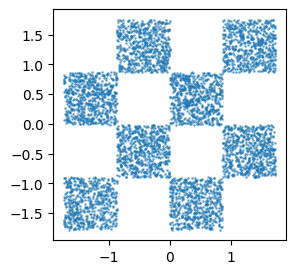

In [2]:
plt.figure(figsize=(3, 3))
plt.scatter(train_data.numpy()[:,0], train_data.numpy()[:,1], s=1.0, alpha=0.5)
plt.show()

It's also good to visualize the density as sometimes generative models overfit particular region of space. Once models are trained, when you sample from them, plot the two densities side-by-side to compare real & synthetic dataset.

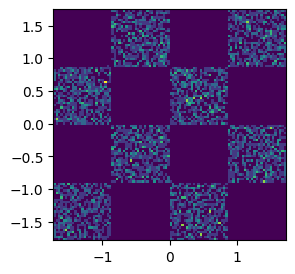

In [3]:
plt.figure(figsize=(3, 3))
plt.hist2d(train_data.numpy()[:,0], train_data.numpy()[:,1], bins=100)
plt.show()

#### Moon (use this one only if your models struggle on checkerboard)

In [8]:
import torch
import math
from sklearn import datasets
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the dataset
    """
    data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
    return torch.from_numpy(data)

Let's plot a large batch, to see what the dataset looks like.

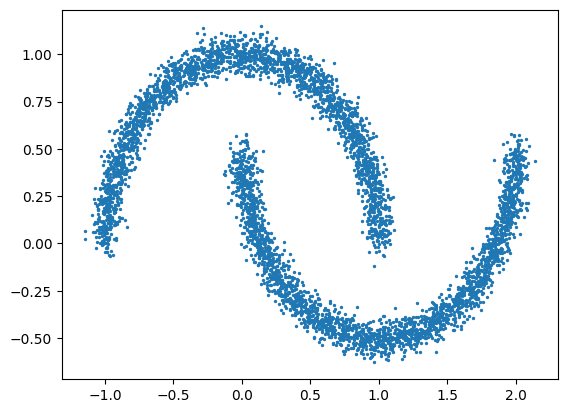

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(5000)

plt.scatter(batch[:,0], batch[:,1], s=2.0)
plt.show()

It's also good to visualize the density as sometimes generative models overfit particular areas. Once models are trained, when you sample from them, plot the two densities side-by-side to compare real & synthetic dataset.

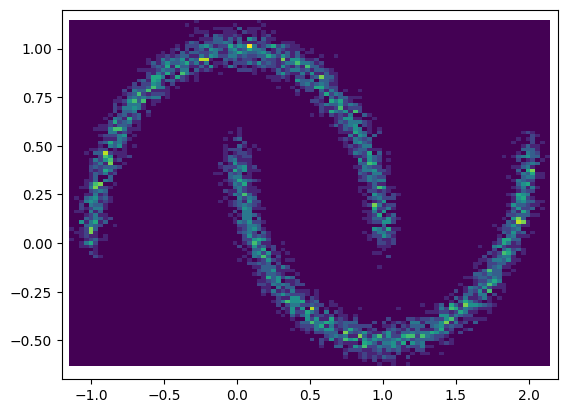

In [10]:
plt.hist2d(batch.numpy()[:,0], batch.numpy()[:,1], bins=100)
plt.xlim([-1.2,2.2])
plt.ylim([-0.7,1.2])
plt.show()

In [11]:
def generate_batch_checkerboard(num_datapoints: int) -> np.ndarray:
  """Checkerboard dataset."""
  x1 = np.random.rand(num_datapoints) * 4 - 2
  x2 = np.random.rand(num_datapoints) - np.random.randint(0, 2, [num_datapoints]) * 2. + np.floor(x1) % 2
  data = np.stack([x1, x2]).T * 2
  data = (data - data.mean(axis=0)) / data.std(axis=0) # normalize
  return torch.from_numpy(data.astype(np.float32))

def generate_batch_moons(num_datapoints: int) -> np.ndarray:
  """Moons dataset."""
  data = datasets.make_moons(n_samples=num_datapoints, noise=0.05)[0].astype(np.float32)
  return torch.from_numpy(data)

def generate_batching(num_datapoints: int, dataset_type: str) -> np.ndarray:
  """Generates a batch of data points based on the choosen type of dataset."""
  if dataset_type == 'checkerboard':
    return generate_batch_checkerboard(num_datapoints)
  elif dataset_type == 'moons':
    return generate_batch_moons(num_datapoints)
  else:
    raise ValueError("Unknown dataset type. Use 'checkerboard' or 'moons'.")

----
## Generative Adversarial Networks

GANs structure is based on modeling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise $\epsilon$?**

> $N$ is the dimension of the input of $f_{\theta}$. Each dimension of the $N$ input dimensions is interesting because it provides a random variable. In the end, when $N$ is bigger, the system has more degrees of freedom, so it has a bigger capacity to transform the noise into something realistic. Of course, if $N$ is too big, it can be computationnaly heavier to train the model (and there is a potential risk of overfitting). But the main risk is to have a $N$ which is too low: in that specific case, the system doesn't have enough degrees of freedom and it can't generate many different things. It will underfit and fail to produce realistic things.

By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that for the generator fixed, the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$
, where JSD is the JS divergence used to measure the similarity of two distributions.
$$JSD(p_\theta \| p_D) = \frac{1}{2} \mathbb{E}_{p_D} \left[ log(\frac{2p_D}{p_D+p_\theta}) \right] + \frac{1}{2} \mathbb{E}_{p_\theta} \left[ log(\frac{2p_\theta}{p_D+p_\theta}) \right]$$
So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

> If $p_{\theta}$ and $p_D$ are too different, $\mathcal{L}_D$ will be constant to $2 \log 2$  and the gradient will be zero, so the model won't improve very much.

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

> The generator will improve a bit (compared to the discriminator that won't) improve, but after that, the model will globally stop improving because the generator will be able to fool easily the discriminator, even with generations far away from realistic outputs...

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D two-moons shape with some noise.

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [33]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 6

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, 12)
        self.fc2 = nn.Linear(12, 2)

    def __call__(self, z):
        return self.fc2(F.relu(self.fc1(z)))

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)


# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 12)
        self.fc2 = nn.Linear(12, 1)

    def __call__(self, x):
        return self.fc2(F.relu(self.fc1(x)))

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

step 0: discriminator: 1.460e+00, generator: 7.763e-01


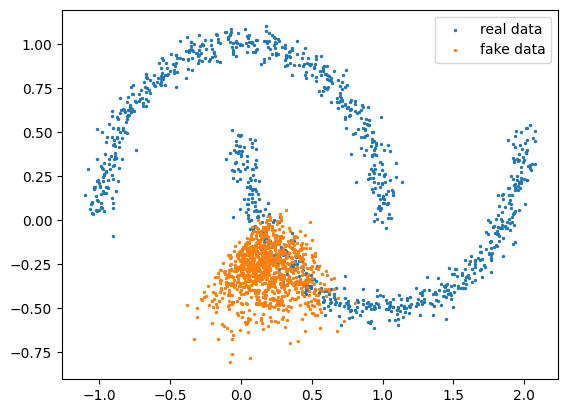

step 1000: discriminator: 1.361e+00, generator: 7.133e-01


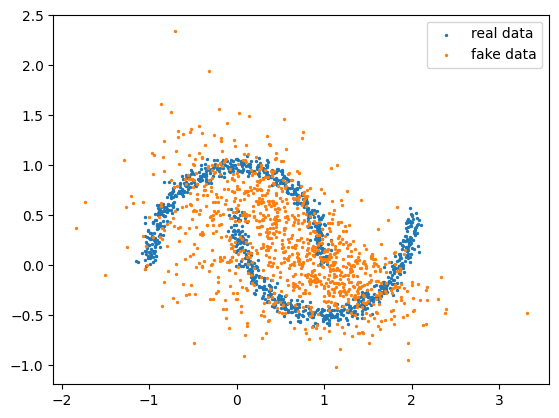

step 2000: discriminator: 1.333e+00, generator: 7.523e-01


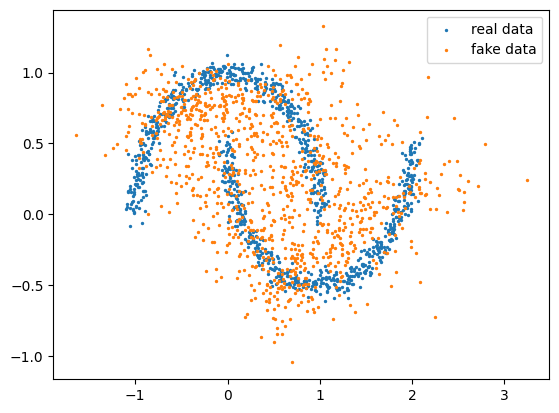

step 3000: discriminator: 1.360e+00, generator: 7.265e-01


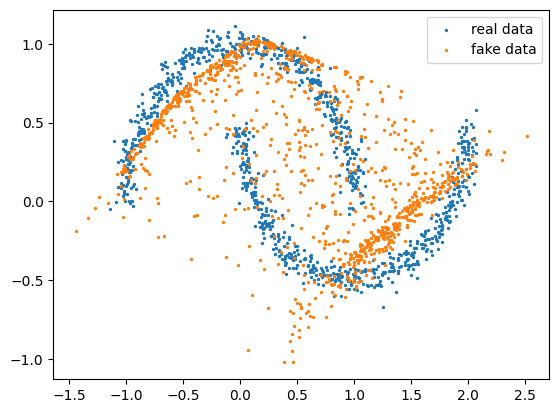

step 4000: discriminator: 1.365e+00, generator: 7.099e-01


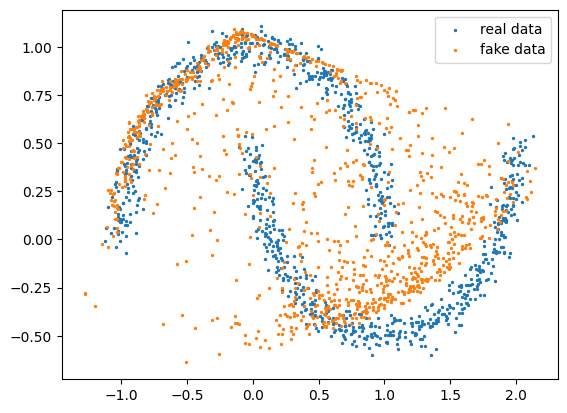

step 5000: discriminator: 1.382e+00, generator: 7.234e-01


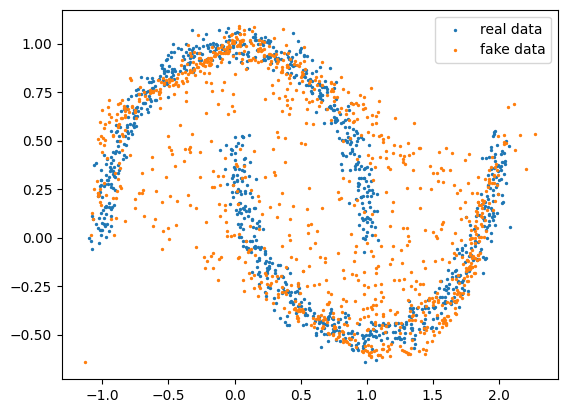

step 6000: discriminator: 1.354e+00, generator: 7.131e-01


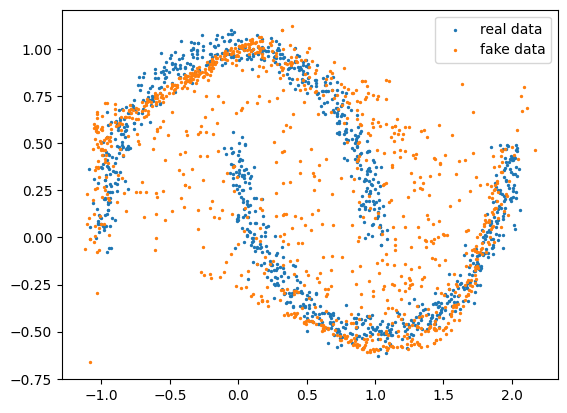

step 7000: discriminator: 1.356e+00, generator: 7.227e-01


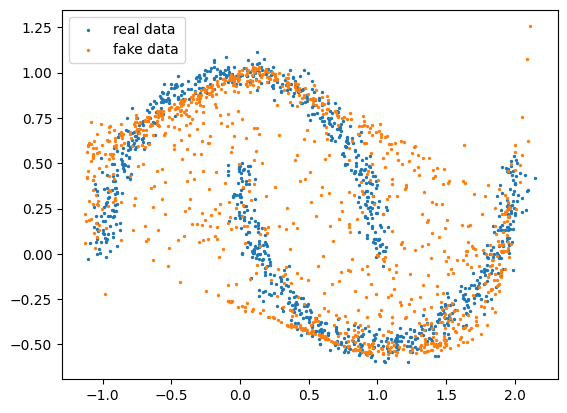

step 8000: discriminator: 1.342e+00, generator: 7.321e-01


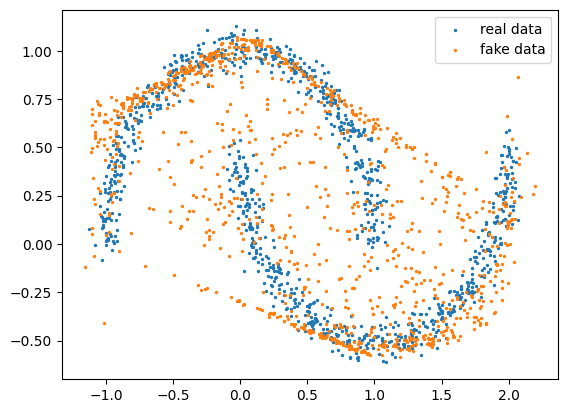

step 9000: discriminator: 1.342e+00, generator: 7.502e-01


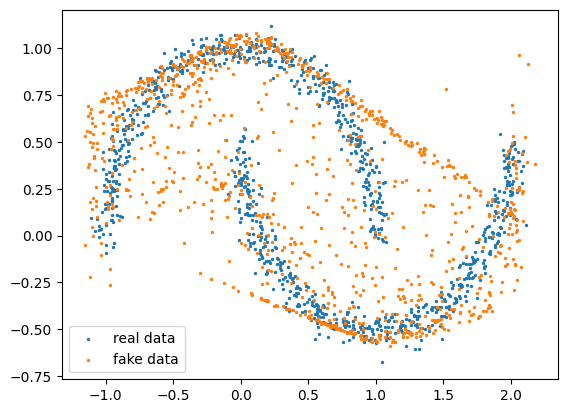

step 10000: discriminator: 1.351e+00, generator: 7.390e-01


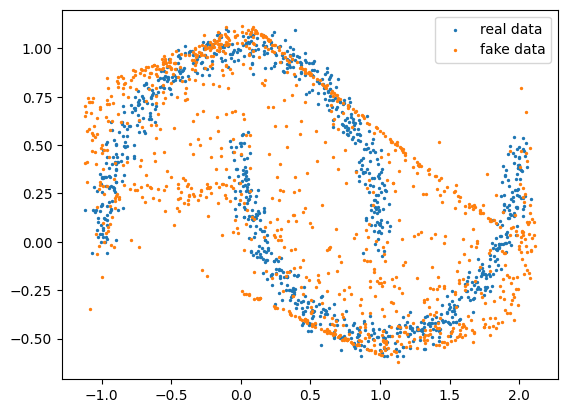

step 11000: discriminator: 1.337e+00, generator: 7.227e-01


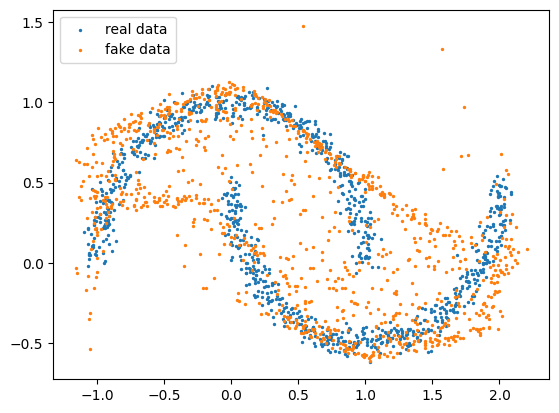

step 12000: discriminator: 1.336e+00, generator: 7.626e-01


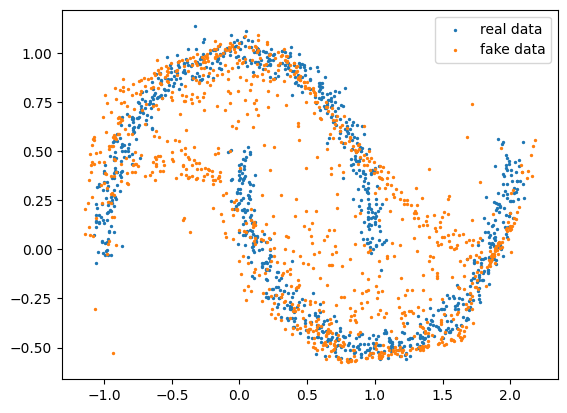

step 13000: discriminator: 1.328e+00, generator: 7.470e-01


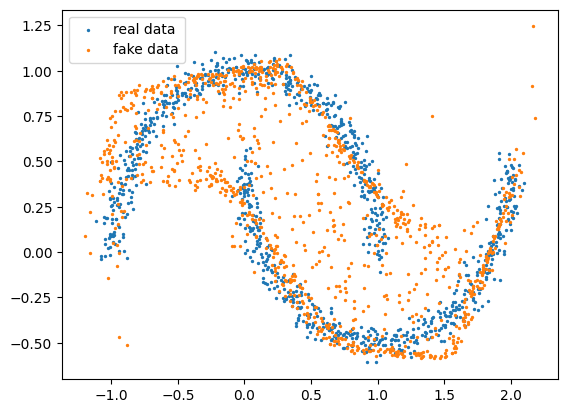

step 14000: discriminator: 1.332e+00, generator: 7.179e-01


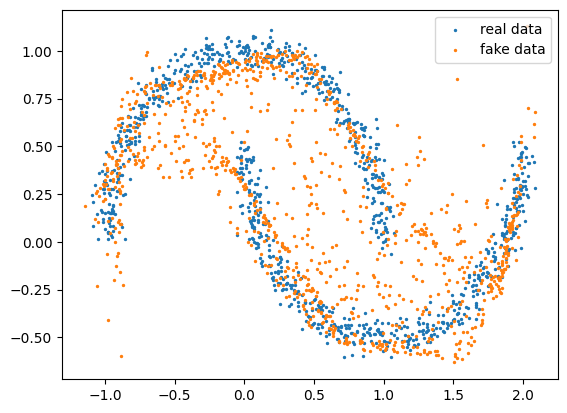

step 15000: discriminator: 1.343e+00, generator: 7.519e-01


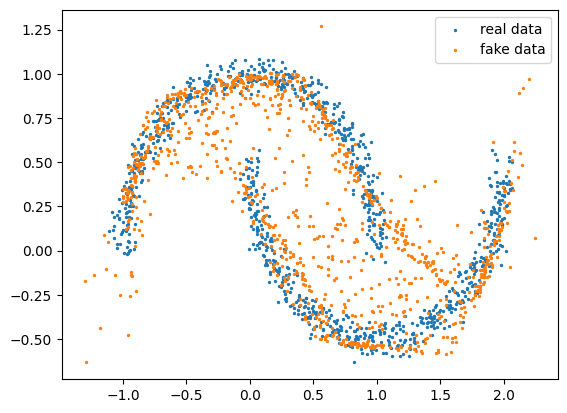

step 16000: discriminator: 1.353e+00, generator: 7.392e-01


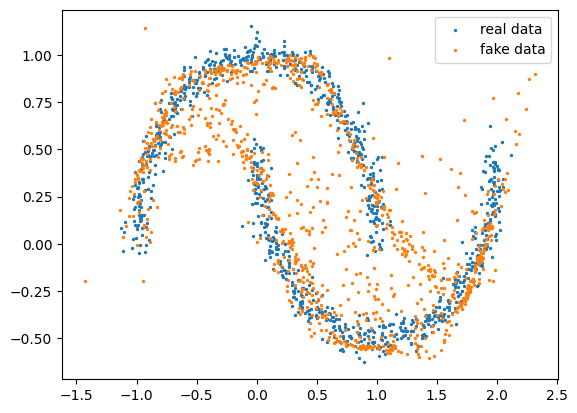

step 17000: discriminator: 1.339e+00, generator: 7.463e-01


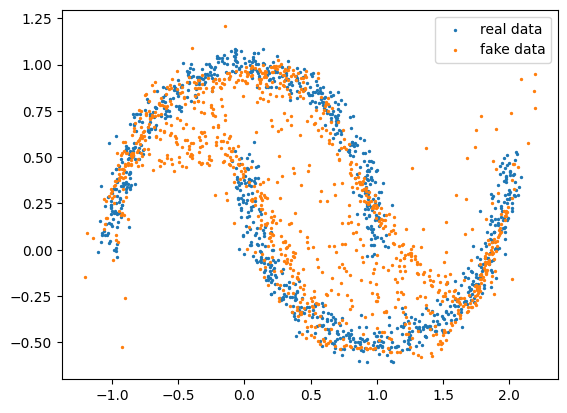

step 18000: discriminator: 1.377e+00, generator: 7.801e-01


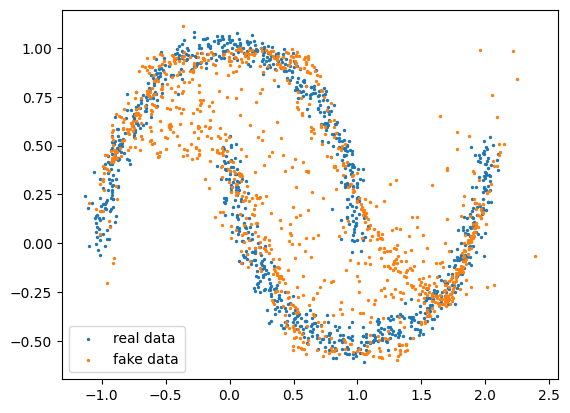

step 19000: discriminator: 1.359e+00, generator: 7.533e-01


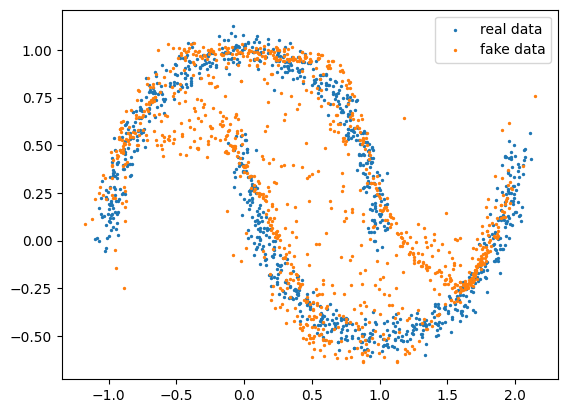

step 20000: discriminator: 1.305e+00, generator: 7.482e-01


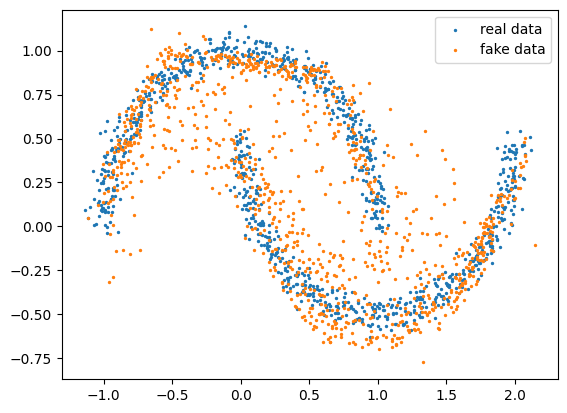

In [35]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 3
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 128

generator = Generator()
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
discriminator = Discriminator()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN)
        #
        # == COMPUTE THE DISCRIMINATOR LOSS HERE ==
        #
        disc_loss = -torch.mean(torch.log(torch.sigmoid(discriminator(real_batch)))+torch.log(1-torch.sigmoid(discriminator(fake_batch.detach()))))
        disc_loss.backward()
        optim_disc.step()
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)
    #
    # == COMPUTE THE GENERATOR LOSS HERE
    #
    # gen_loss = torch.mean(torch.log(1-torch.sigmoid(discriminator(fake_batch))))
    gen_loss=-torch.mean(torch.log(torch.sigmoid(discriminator(fake_batch))))
    gen_loss.backward()
    optim_gen.step()
    if i%1000 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

> When the discriminator is trained very well, we rapidly have $1-D(x)=1$ for all generated samples. So the gradient is also very low, and both generator and discriminator stop improving.

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ to avoid gradient vanishing.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

> If `N_PRIOR` is too low, the model doesn't have enough degrees of freedom to sample a "complex" form such as "two moons". Moreover, it is important to increase the depth of the generator because with only a depth of one, the model won't be able to create complex forms, even with a high `N_PRIOR`. If the width or the depth of the model is too huge, the model might overfit. If `TRAIN_RATIO` is too high, it is not good as we said before because the discriminator becomes very rapidly very good compared to the basic generator, and due the vanishing gradient, everything stops improving. It is quite difficult to find a good balance between parameters.

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)
- A Style-Based Generator Architecture for Generative Adversarial Networks *(Karras et al.)* [arxiv:1812.04948v3](https://arxiv.org/abs/1812.04948v3)

----
## Variational AutoEncoders

Another well-known approach to generative modeling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.
$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]$$

**Q8: Prove this equivalence.**

> Let us derive this results from : $D_{KL}(p_D \| p_\theta) = \int log(\frac{p_D}{p_\theta}) p_D(x) dx$
<br><br>
> $D_{KL}(p_D \| p_\theta) = \int log(p_D) p_D - \int log(p_\theta) p_D$
<br>
> Thus, minimizing $D_{KL}(p_D \| p_\theta)$ give us :
<br><br>
> $\argmin_{\theta} \{ \int log(p_D) p_D - \int log(p_\theta) p_D\} = \argmin_{\theta} \{ - \int log(p_\theta) p_D \} = \argmax_{\theta} \{\int log(p_\theta) p_D\} = \argmax_{\theta} \{ \mathbb{E}_{p_D} \}$
<br><br>
> Which yields the expected equivalence (indeed each step of our reasoning is equivalent because we used argmin/argmax, thus we have both direction of the proof).

However, the classes of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution as: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)dz$ is an infinite mixture of Gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce another, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms forms a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

![VAE](./vae-gaussian.png)

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

> It is important to fully grasp what is happening here. During training, we perform regularization so that our probabilistic encoder distribution is "near" the prior (which ultimately yields to regularize in order to achieve a normed-scaled gaussian law). But, this does not means it is fully achieved, the data distibution can be rather inhomogenous and results in an highly unstable law. 
<br>
> That would not be an issue if our only task was to encode and reconstruct data, because at the end of the day the decoder is trained to be "near" the original data distribution. Thus, when receiving encoded data, it won't have a hard time decoding it back (because the encoder distribution fit the expected distribution for the decoder). **But**, when we are generating, we want to create data that never existed in the first place so that those data fit the original data distribution. The efficient way we do that is sample from the encoder space using a gaussian law (and praying that the training has correctly fitted the encoder law with our prior $p(z)$). Unfortunately, if the fitting between both law did not succeed, we are basically sampling out-of-distribution data which will return very strange images... (in the case of image generation). To try to address that, one could -for example- weight the regularization term in order to make it more important when the original distribution is highly inhomogenous. But that would come with a cost, we would get more "cliché" images than complexe one.

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

> To derive this formula, we first need to write the gaussian density for both : 
<br><br>
>$\mathcal{N}\Big(z|\, \mu_\phi(x), \operatorname{Diag}(\sigma_\phi^2(x))\Big) 
= \prod_{j=1}^{d} \frac{1}{\sqrt{2\pi\,\sigma_{\phi,j}^2(x)}}
\exp\left(-\frac{\left(z_j - \mu_{\phi,j}(x)\right)^2}{2\,\sigma_{\phi,j}^2(x)}\right)$
<br><br>
> $\mathcal{N}(z|\, 0; Id) = \frac{1}{(2\pi)^{d/2}} \exp\left(-\frac{1}{2} z^\top z\right) $
<br><br>
> Recall the Kullback Leibler Divergence : 
<br><br>
> $D_{KL}(q_\phi(z | x) \| p(z)) = \int q_\phi(z | x) log\left(\frac{q_\phi(z | x)}{p(z)}\right)$
<br><br>
> Let us derive the log value : $log\left(\frac{q_\phi(z | x)}{p(z)}\right) = \frac{1}{2} z^\top z - \sum_{j=1}^d \left(log(\sigma_{\phi,j}(x)) +\frac{\left(z_j - \mu_{\phi,j}(x)\right)^2}{2\,\sigma_{\phi,j}^2(x)} \right) $
<br><br>
> Before taking the expectation of this quantity, let us perform some modification to ease the computation :
<br><br>
> $log\left(\frac{q_\phi(z | x)}{p(z)}\right) =   \sum_{j=1}^d \left( \frac{1}{2} (z_j-\mu_{\phi,j}(x))^2 + z_j \mu_{\phi,j}(x) - \frac{1}{2} \mu_{\phi,j}^2(x) - log(\sigma_{\phi,j}(x)) -\frac{\left(z_j - \mu_{\phi,j}(x)\right)^2}{2\,\sigma_{\phi,j}^2(x)} \right) $
<br><br>
> Then taking the expectation with respect to $q_\phi(z | x)$ which is $\mathcal{N}\Big(\mu_\phi(x), \operatorname{Diag}(\sigma_\phi^2(x))\Big)$ yields :
<br><br>
> $ D_{KL}(q_\phi(z | x) \| p(z)) = \sum_{j=1}^d \left( \frac{1}{2} \sigma_{\phi,j}^2(x) + \mu_{\phi,j}^2(x) - \frac{1}{2} \mu_{\phi,j}^2(x) - log(\sigma_{\phi,j}(x)) -\frac{\sigma_{\phi,j}^2(x)}{2\,\sigma_{\phi,j}^2(x)} \right) $
<br><br>
> Note that we can squared the standard-deviation in the log and divide the log by $\frac{1}{2}$ so that we can take the fraction out :
<br><br>
>  $ D_{KL}(q_\phi(z | x) \| p(z)) = \frac{1}{2} \sum_{j=1}^d \left( \sigma_{\phi,j}^2(x) + \mu_{\phi,j}^2(x) - log(\sigma_{\phi,j}^2(x)) - 1 \right) $
<br><br>
> Thus we retrieved a closed form and easy to use expression for the $D_{KL}$ part of the loss.
<br>
> **Note** that if we take some step back and look at the formula we first derived when applying the log, we observe the term : $\frac{1}{2} z^\top z$. This is the regularization term that we were discussing before (it comes from the prior choosen). Such a term yields that our law does not stray too far from the centred-scaled gaussian. Ultimately, it results on a regularization on the mean and the standard deviation which is represented by the part $\sigma_{\phi,j}^2(x) + \mu_{\phi,j}^2(x)$ of our closed form $D_{KL}$.

We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$.


**Note:** For the following, be careful about the difference between $\mu_\phi, \sigma_\phi$ which define the Gaussian distribution of the *encoder* $q_\phi$ and $\mu_\theta, \sigma_\theta$ which define the Gaussian distribution of the *decoder* $p_\theta$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

> We derive this value the same way we did above (the density as the same form from the other above) :
<br><br>
> Let us note $m$ the dimension of the image space.
<br><br>
> $\log p_\theta(x | z) = - \sum_{j=1}^m \left(log(\sigma_{\theta,j}(z)) +\frac{\left(x_j - \mu_{\theta,j}(z)\right)^2}{2\,\sigma_{\theta,j}^2(z)} \right) $
<br><br>
> Which yields $- \log p_\theta(x | z) = \frac{1}{2} \sum_{j=1}^m \left(log(\sigma_{\theta,j}^2(z)) +\frac{\left(x_j - \mu_{\theta,j}(z)\right)^2}{\sigma_{\theta,j}^2(z)} \right) $

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [12]:
# Choose a value for the latent dimension
LATENT_N = 100

# Define the generator
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(2, LATENT_N)
        self.fc_logvar = nn.Linear(2, LATENT_N)

    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return (mu, logvar)


# Define the discriminator
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(LATENT_N, 2)
        self.fc_logvar = nn.Linear(LATENT_N, 2)

    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$.

step 0: KL: 2.902e+01, rec: 1.600e+00, total: 3.062e+01


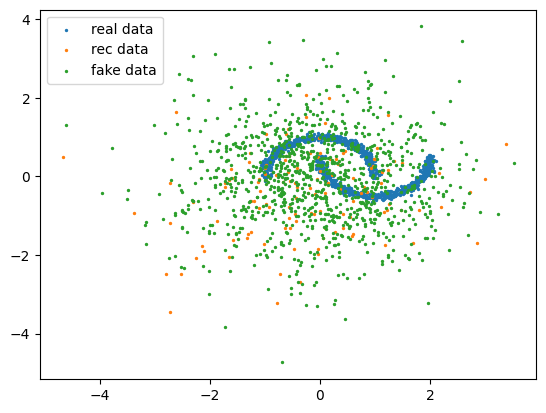

step 1000: KL: 1.025e-01, rec: -8.804e-03, total: 9.374e-02


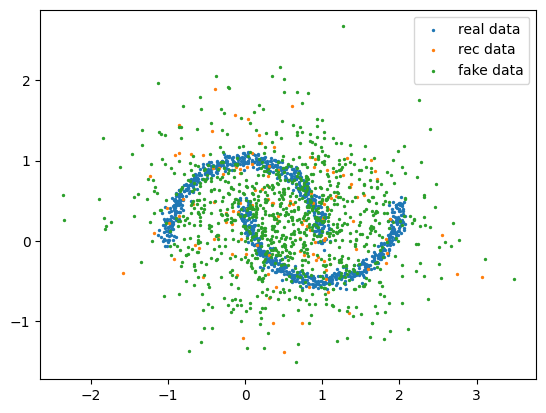

step 2000: KL: 1.772e-01, rec: -3.290e-02, total: 1.443e-01


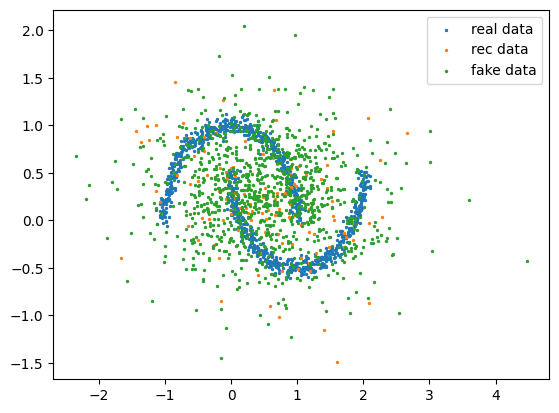

step 3000: KL: 1.781e-01, rec: 2.124e-02, total: 1.993e-01


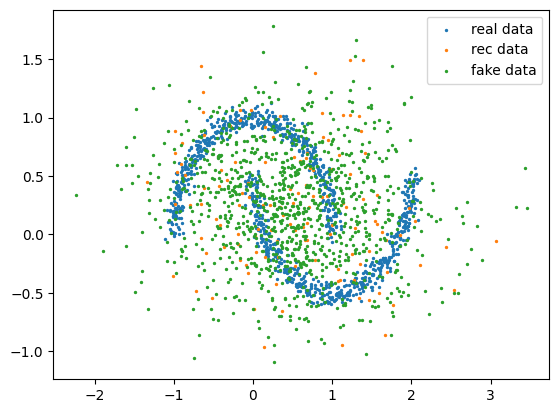

step 4000: KL: 1.875e-01, rec: -4.578e-02, total: 1.417e-01


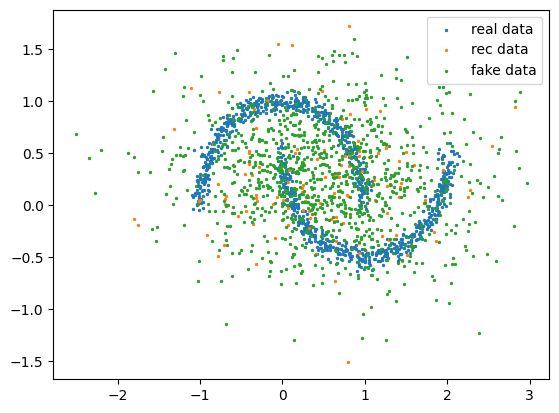

step 5000: KL: 2.425e-01, rec: -1.423e-01, total: 1.003e-01


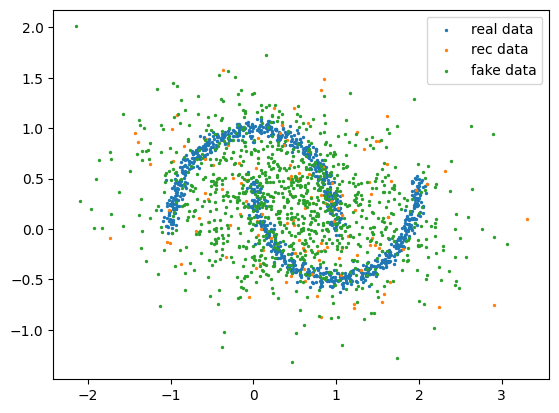

step 6000: KL: 4.658e-01, rec: -3.355e-01, total: 1.303e-01


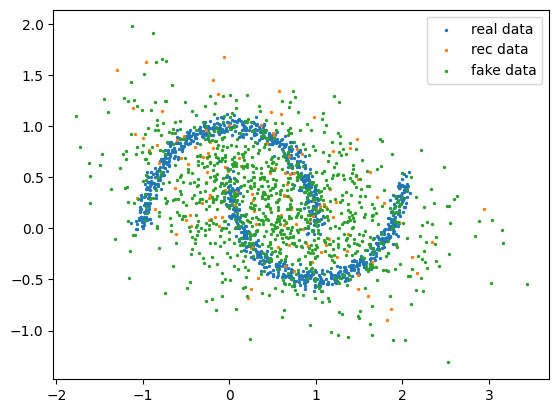

step 7000: KL: 5.020e-01, rec: -4.653e-01, total: 3.672e-02


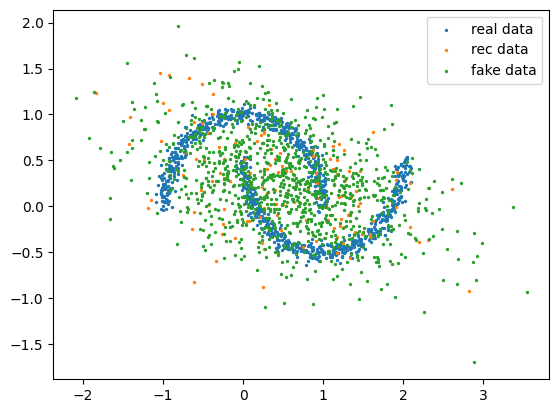

step 8000: KL: 5.243e-01, rec: -3.826e-01, total: 1.417e-01


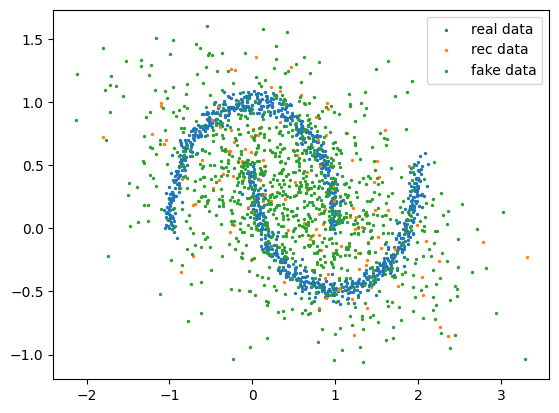

step 9000: KL: 5.331e-01, rec: -4.695e-01, total: 6.365e-02


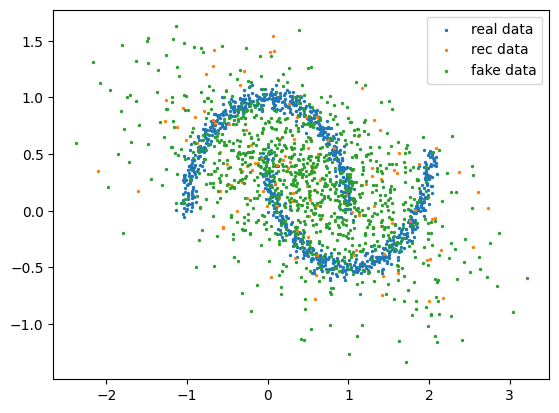

step 10000: KL: 5.291e-01, rec: -5.749e-01, total: -4.581e-02


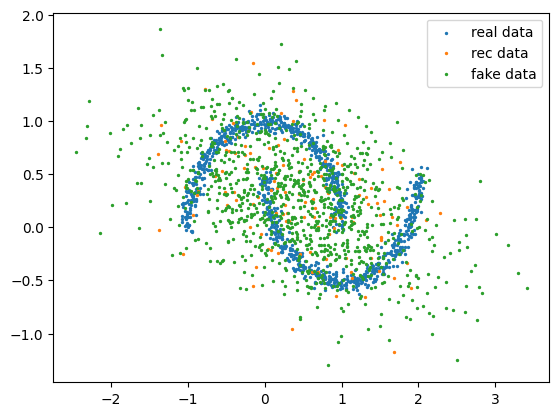

step 11000: KL: 5.210e-01, rec: -4.148e-01, total: 1.062e-01


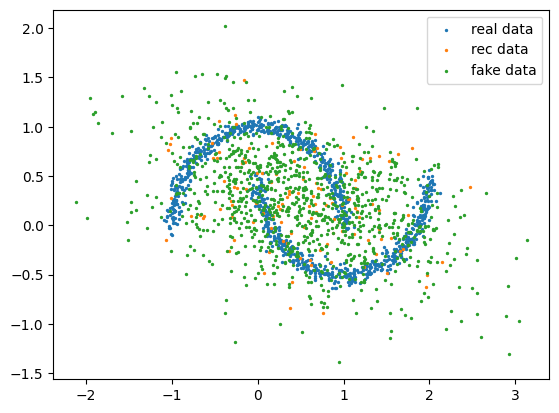

step 12000: KL: 5.371e-01, rec: -4.951e-01, total: 4.200e-02


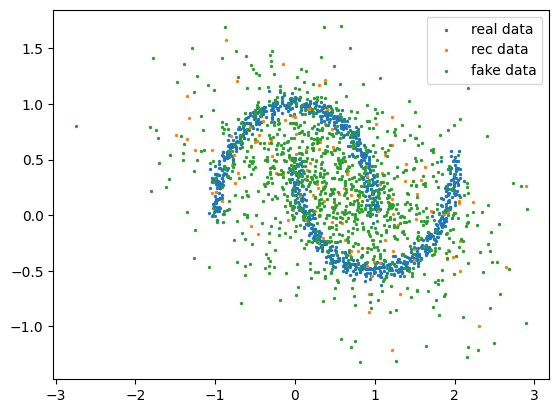

step 13000: KL: 5.195e-01, rec: -5.715e-01, total: -5.198e-02


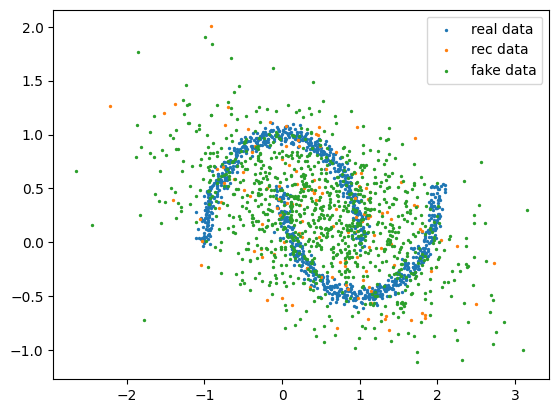

step 14000: KL: 5.364e-01, rec: -4.344e-01, total: 1.021e-01


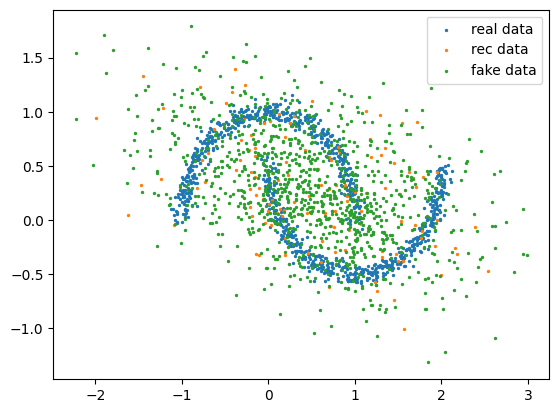

step 15000: KL: 5.204e-01, rec: -4.557e-01, total: 6.469e-02


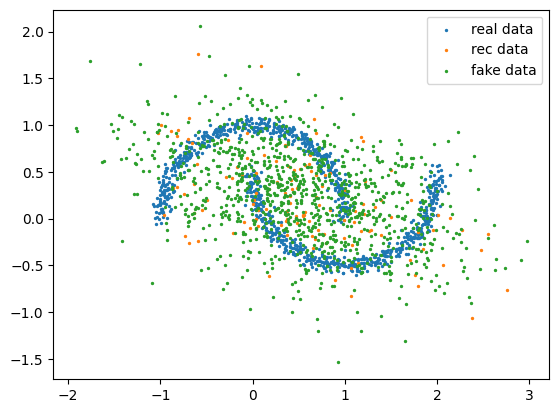

step 16000: KL: 5.258e-01, rec: -4.471e-01, total: 7.871e-02


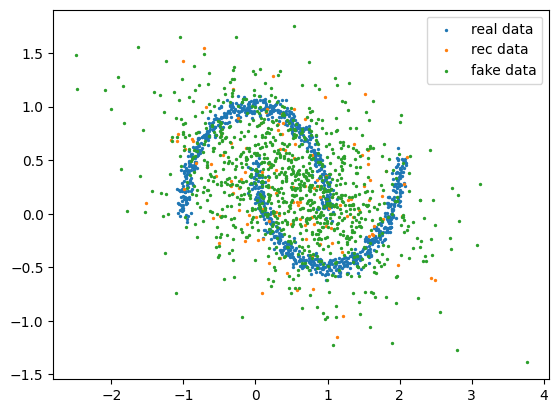

step 17000: KL: 5.374e-01, rec: -4.397e-01, total: 9.768e-02


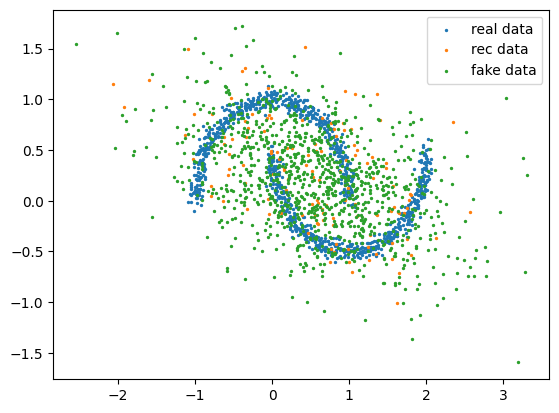

step 18000: KL: 5.300e-01, rec: -4.083e-01, total: 1.216e-01


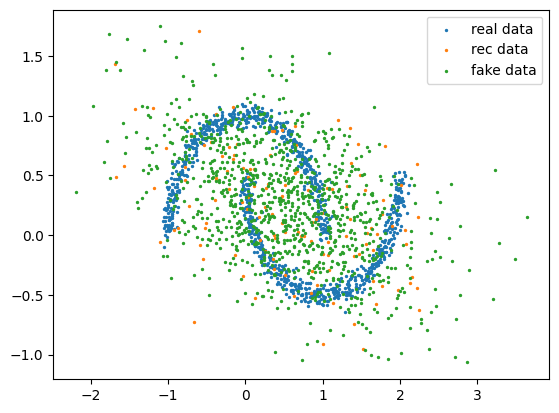

step 19000: KL: 5.424e-01, rec: -5.474e-01, total: -5.042e-03


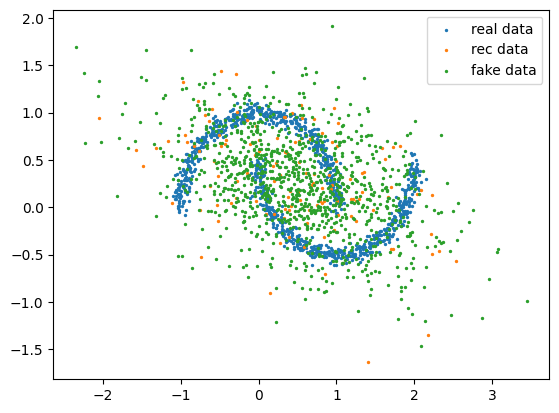

step 20000: KL: 5.398e-01, rec: -5.635e-01, total: -2.373e-02


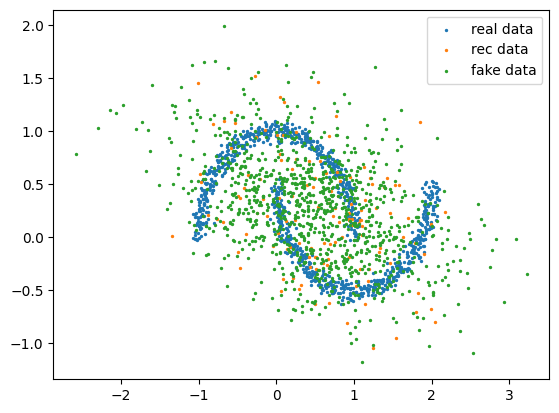

step 21000: KL: 5.307e-01, rec: -4.982e-01, total: 3.250e-02


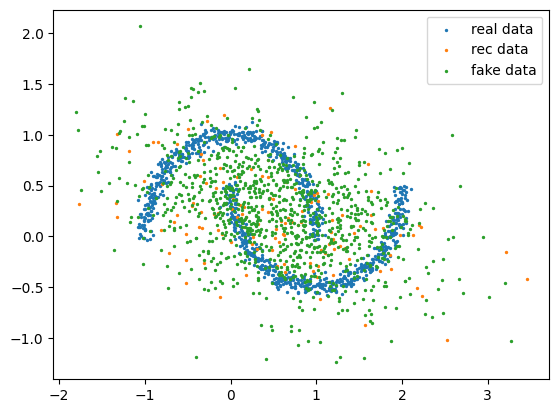

step 22000: KL: 5.304e-01, rec: -3.596e-01, total: 1.707e-01


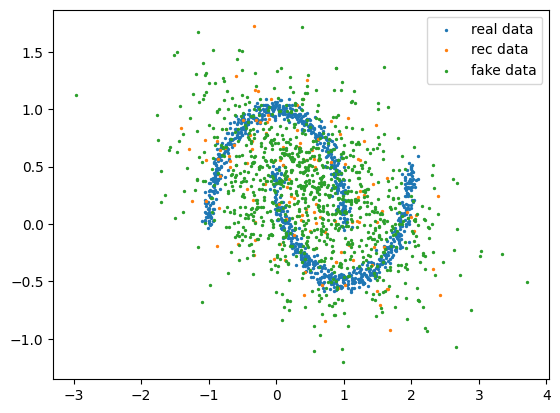

step 23000: KL: 5.449e-01, rec: -4.545e-01, total: 9.037e-02


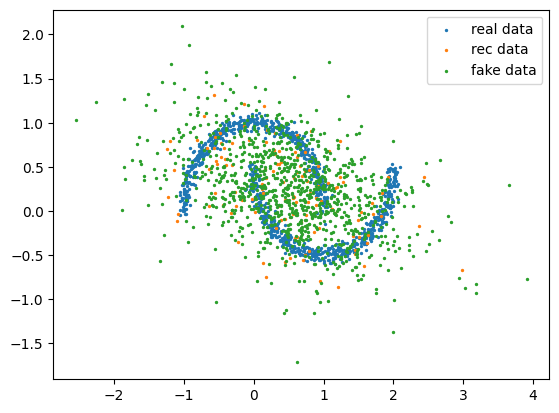

step 24000: KL: 5.348e-01, rec: -4.634e-01, total: 7.148e-02


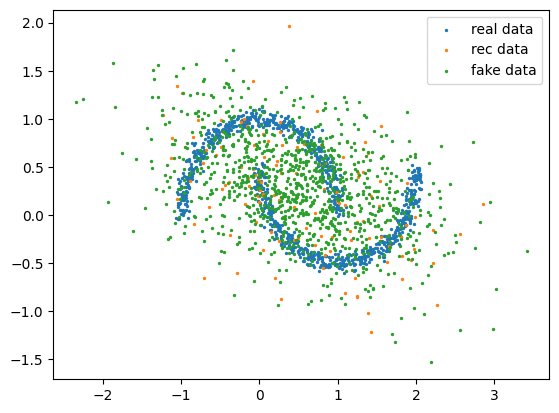

step 25000: KL: 5.338e-01, rec: -4.803e-01, total: 5.355e-02


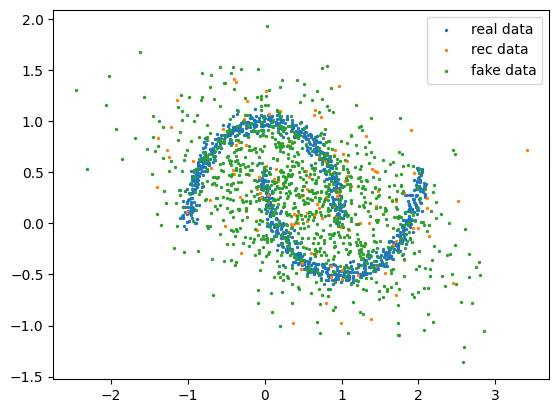

step 26000: KL: 5.345e-01, rec: -4.768e-01, total: 5.771e-02


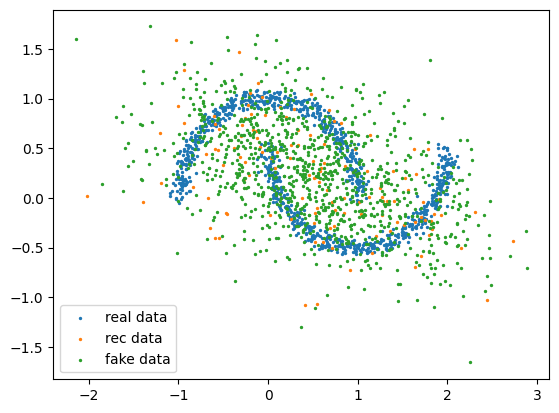

step 27000: KL: 5.324e-01, rec: -5.806e-01, total: -4.813e-02


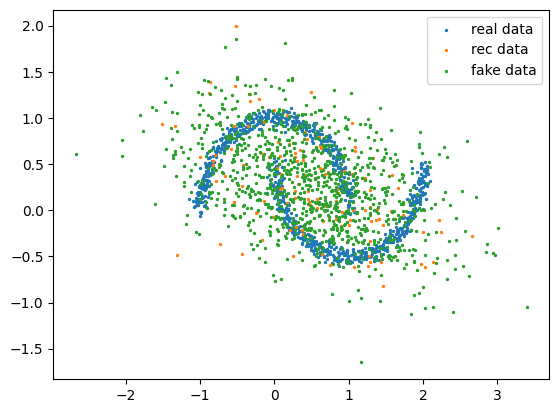

step 28000: KL: 5.393e-01, rec: -5.470e-01, total: -7.667e-03


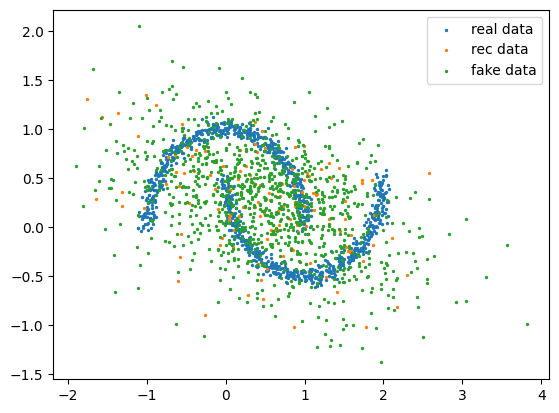

step 29000: KL: 5.407e-01, rec: -2.921e-01, total: 2.486e-01


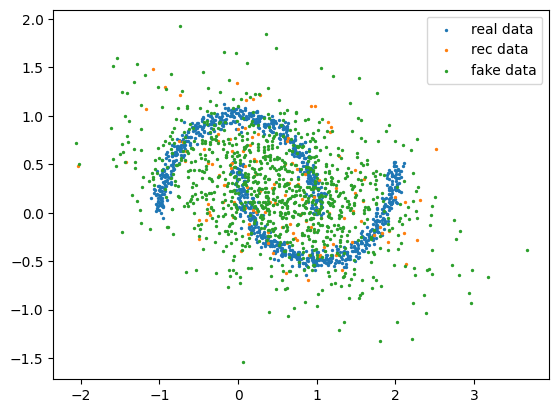

step 30000: KL: 5.388e-01, rec: -5.239e-01, total: 1.497e-02


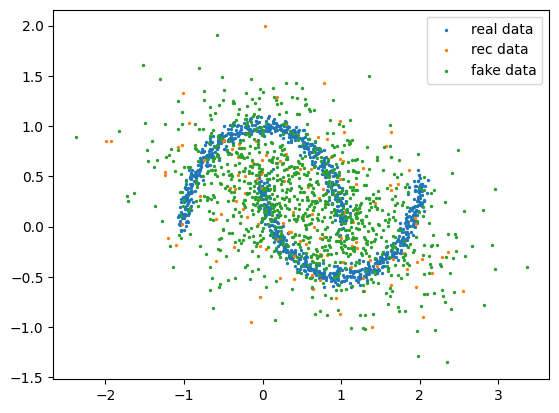

step 31000: KL: 5.471e-01, rec: -5.984e-01, total: -5.127e-02


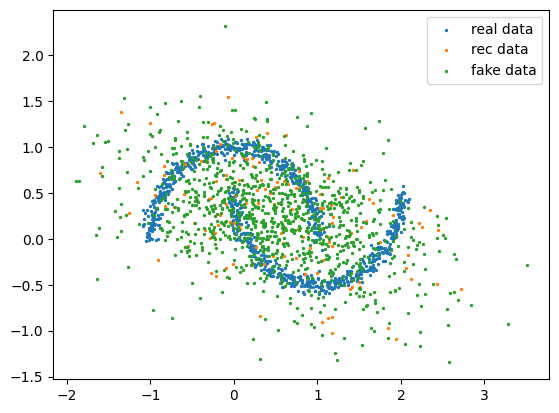

step 32000: KL: 5.322e-01, rec: -3.752e-01, total: 1.570e-01


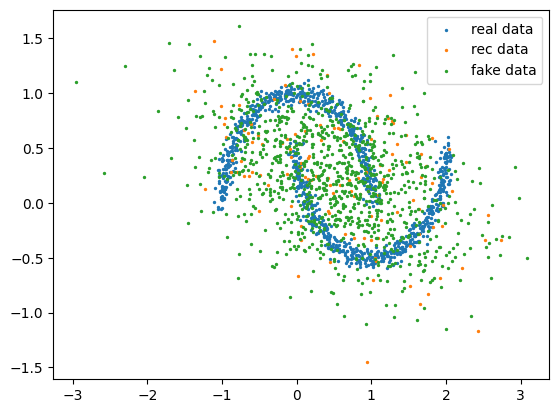

step 33000: KL: 5.422e-01, rec: -5.495e-01, total: -7.331e-03


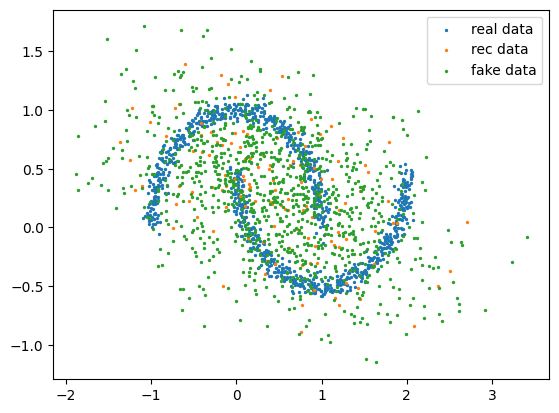

step 34000: KL: 5.437e-01, rec: -3.945e-01, total: 1.492e-01


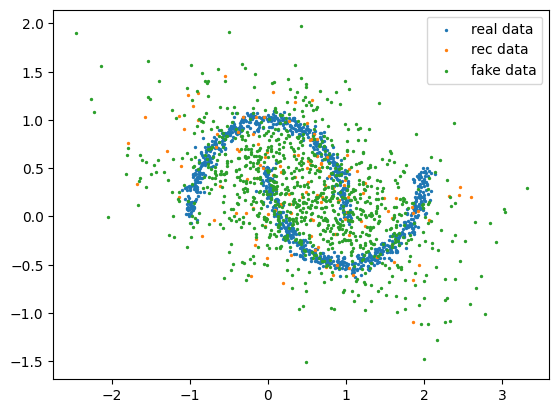

step 35000: KL: 5.453e-01, rec: -4.221e-01, total: 1.232e-01


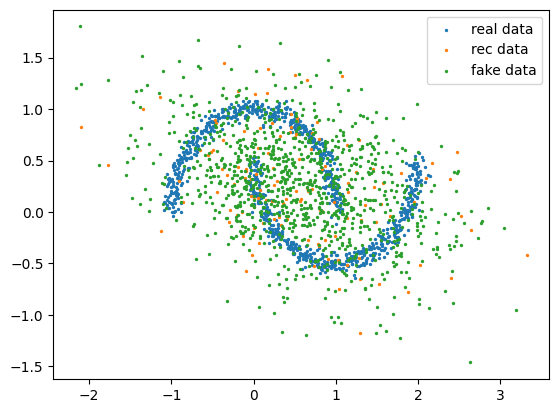

step 36000: KL: 5.309e-01, rec: -3.996e-01, total: 1.313e-01


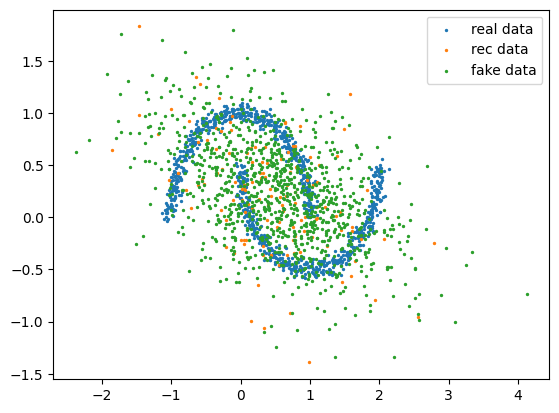

step 37000: KL: 5.339e-01, rec: -5.243e-01, total: 9.627e-03


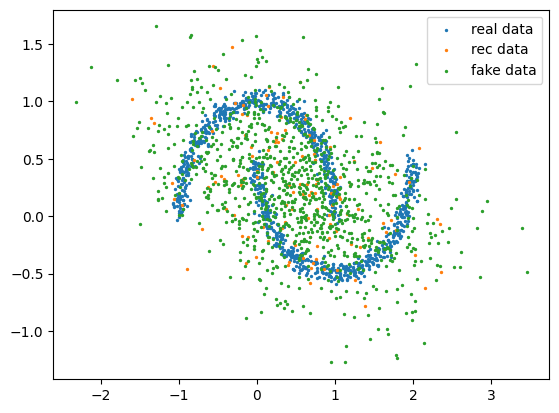

step 38000: KL: 5.469e-01, rec: -4.883e-01, total: 5.859e-02


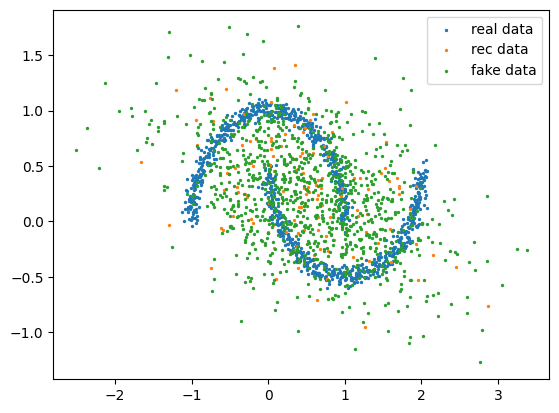

step 39000: KL: 5.388e-01, rec: -4.191e-01, total: 1.196e-01


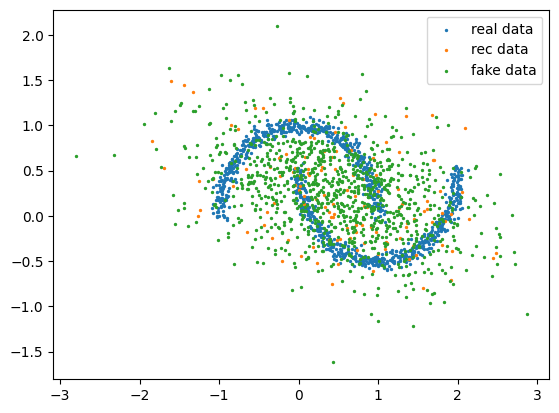

step 40000: KL: 5.455e-01, rec: -5.207e-01, total: 2.477e-02


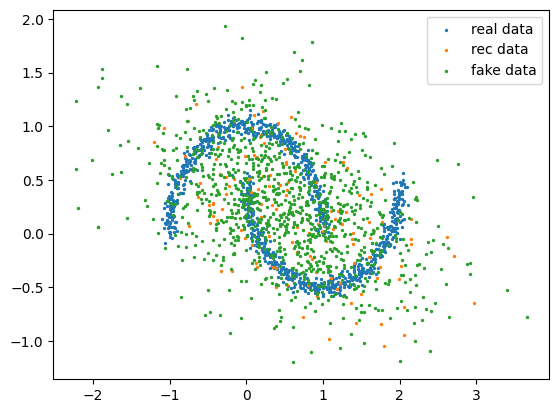

In [25]:
# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128
# Choose the dataset type
DATASET_TYPE = 'moons'  # 'checkerboard' or 'moons'
generate_selected_batch = lambda num_datapoints: generate_batching(num_datapoints, DATASET_TYPE)

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()

    x = generate_selected_batch(BATCHLEN)

    enc_mu, enc_logvar = encoder(x)
    #
    # COMPUTE THE KL PART OF THE LOSS HERE
    #
    loss_kl = 0.5*torch.sum(enc_mu**2 + torch.exp(enc_logvar) - enc_logvar - 1, dim=1)
    loss_kl = torch.mean(loss_kl)
    #
    # SAMPLE z FROM q(z|x) HERE
    #
    z = enc_mu + torch.exp(0.5*enc_logvar)*torch.normal(torch.zeros(BATCHLEN, LATENT_N), 1.0)

    dec_mu, dec_logvar = decoder(z)
    #
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    #
    loss_rec = 0.5*torch.sum((x - dec_mu)**2 / torch.exp(dec_logvar) + dec_logvar, dim=1)
    loss_rec = torch.mean(loss_rec)

    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}, total: {:.3e}'.format(i, float(loss_kl), float(loss_rec), float(loss_kl + loss_rec)))
        # plot the result
        real_batch = generate_selected_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

> We observe here one of the issue that we were mentionning in the introduction : The model, unable to perfectly fit the gaussian distribution with the moon, results in interpolated values in between both croissant. This is because the training method minimized a difference between distribution parameters, thus, resulting in an irreducible error because the model could not adapt correctly a multivariate gaussian to our distribution. Obviously, it is also an issue of our model complexity. Indeed, a much more complex model would yields better results because it would have enough parameters to correctly fit the data (This is what we observe in question 13).

**Q12: Try hardcoding $\sigma_\theta(z)$ to some small value (like 1E-4) rather than allowing the decoder to learn it. What does it change?**

In [29]:
# Define the variance stuck discriminator
class StuckDecoder(nn.Module):
    def __init__(self, var=1e-4):
        super().__init__()
        self.fc_mu = nn.Linear(LATENT_N, 2)
        self.logvar = np.log(var)

    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        mu = self.fc_mu(z)
        logvar = torch.tensor(self.logvar).expand_as(mu)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

Training with variance: 0.0001
step 0: KL: 3.126e+01, rec: 1.193e+04, total: 1.196e+04
decoder var: 0.00010000000000000006


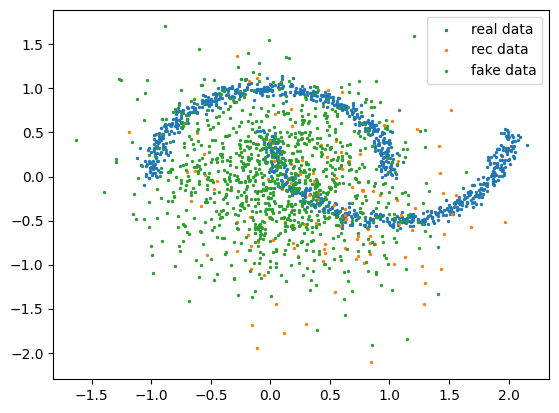

step 10000: KL: 9.593e+00, rec: -7.362e+00, total: 2.231e+00
decoder var: 0.00010000000000000006


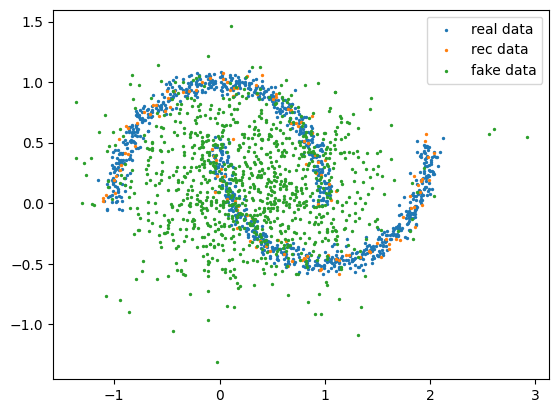

step 20000: KL: 8.363e+00, rec: -7.836e+00, total: 5.267e-01
decoder var: 0.00010000000000000006


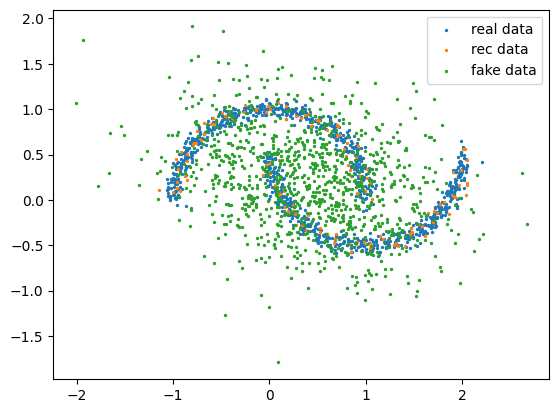

step 30000: KL: 8.343e+00, rec: -7.572e+00, total: 7.706e-01
decoder var: 0.00010000000000000006


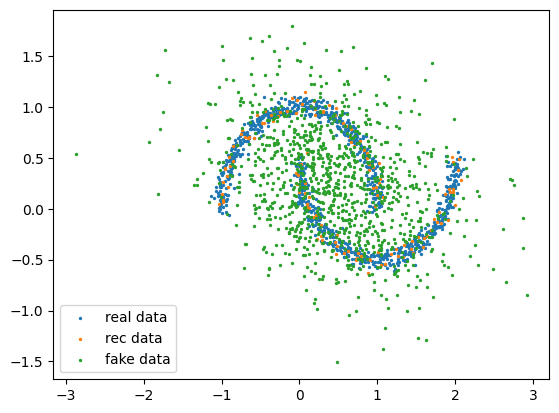

step 40000: KL: 8.323e+00, rec: -7.399e+00, total: 9.246e-01
decoder var: 0.00010000000000000006


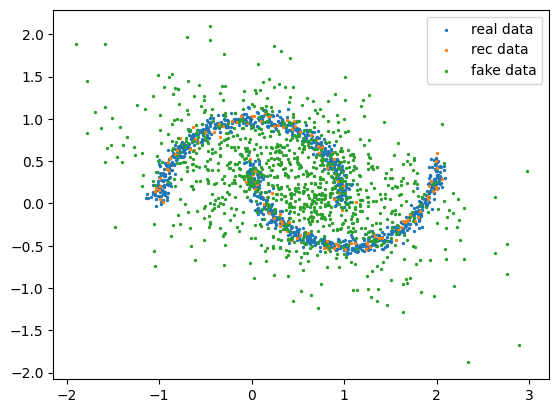

Training with variance: 100.0
step 0: KL: 2.843e+01, rec: 4.622e+00, total: 3.305e+01
decoder var: 100.00000000000001


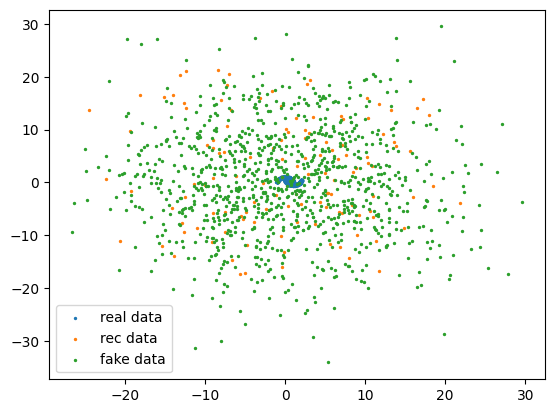

step 10000: KL: 8.951e-06, rec: 4.610e+00, total: 4.610e+00
decoder var: 100.00000000000001


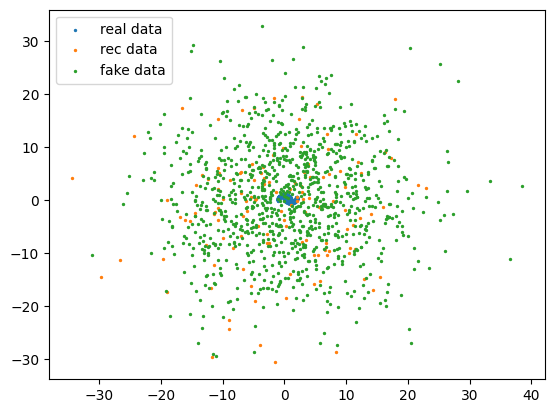

step 20000: KL: 7.242e-06, rec: 4.610e+00, total: 4.610e+00
decoder var: 100.00000000000001


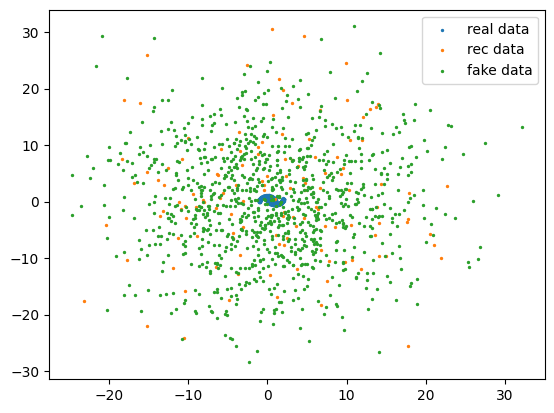

step 30000: KL: 8.196e-06, rec: 4.610e+00, total: 4.610e+00
decoder var: 100.00000000000001


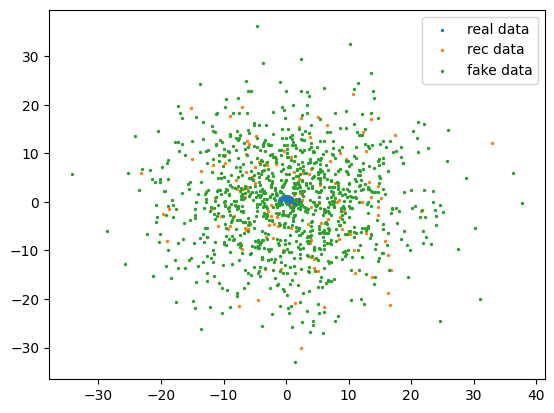

step 40000: KL: 9.010e-06, rec: 4.610e+00, total: 4.610e+00
decoder var: 100.00000000000001


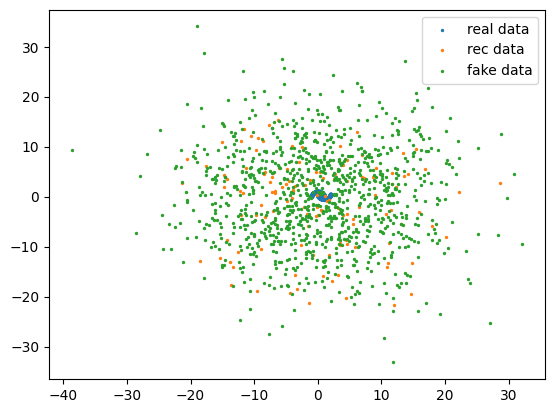

In [33]:
# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128
# Choose the dataset type
DATASET_TYPE = 'moons'  # 'checkerboard' or 'moons'
generate_selected_batch = lambda num_datapoints: generate_batching(num_datapoints, DATASET_TYPE)

var_list = [1e-4, 1e2]

for var in var_list:
    print('Training with variance: {}'.format(var))
    encoder = Encoder()
    optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
    decoder = StuckDecoder(var)
    optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

    for i in range(N_ITER):
        encoder.zero_grad()
        decoder.zero_grad()

        x = generate_selected_batch(BATCHLEN)

        enc_mu, enc_logvar = encoder(x)
        #
        # COMPUTE THE KL PART OF THE LOSS HERE
        #
        loss_kl = 0.5*torch.sum(enc_mu**2 + torch.exp(enc_logvar) - enc_logvar - 1, dim=1)
        loss_kl = torch.mean(loss_kl)
        #
        # SAMPLE z FROM q(z|x) HERE
        #
        z = enc_mu + torch.exp(0.5*enc_logvar)*torch.normal(torch.zeros(BATCHLEN, LATENT_N), 1.0)

        dec_mu, dec_logvar = decoder(z)
        #
        # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
        #
        loss_rec = 0.5*torch.sum((x - dec_mu)**2 / torch.exp(dec_logvar) + dec_logvar, dim=1)
        loss_rec = torch.mean(loss_rec)

        (loss_kl + loss_rec).backward()
        optim_enc.step()
        optim_dec.step()
        if i%10000 == 0:
            print('step {}: KL: {:.3e}, rec: {:.3e}, total: {:.3e}'.format(i, float(loss_kl), float(loss_rec), float(loss_kl + loss_rec)))
            print('decoder var: {}'.format(torch.exp(dec_logvar).mean()))
            # plot the result
            real_batch = generate_selected_batch(1024)
            rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
            fake_batch = decoder.generate(1024).detach()
            plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
            plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
            plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
            plt.legend()
            plt.show()

> From the first plot, it would appear that we are, in fewer steps, more precise (with small fixed variance). This is rather obvious but reducing standard deviation implies that our samples are going to be nearer to the mean. Thus the method trained here only search to correctly fit the center of our predicted distribution (not its variance size).
<br><br>
> This could at first seems to yields good results (for small fixed variance) but that results in fact in unprecise prediction at the end of the training (it could be either too small or too big variance size). Indeed, the VAE method cannot precisely fit the distribution if the fitting variance is fixed. To observe how terrible this can becomes we can just take a look at the test for a huge variance. It is basicaly impossible for the model to define a proper mean, it will only somehow predict it with huge possible error. 
<br><br>
> In our setting here, the data distibution can easily be sampled and thus, observed. Which allow us to clearly see that our choice of variance is wrong. But for more complex distribution (like images), it would be much harder to correctly inspect each variance. This shows how important it is to have a training loss taking each possible parameter (degree of freedom) of our density into account.

**Q13: How do the power of encoder and decoder affect the overall training of the VAE?**

In [17]:
# Choosable encoder
class nEncoder(nn.Module):
    def __init__(self, layer_dim=256, latent_n=LATENT_N):
        super().__init__()
        self.fc_inter_mu = nn.Linear(2, layer_dim)
        self.fc_inter_logvar = nn.Linear(2, layer_dim)
        self.fc_mu = nn.Linear(layer_dim, latent_n)
        self.fc_logvar = nn.Linear(layer_dim, latent_n)
        self.reLU = nn.ReLU()

    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        x_mu = self.reLU(self.fc_inter_mu(x))
        x_logvar = self.reLU(self.fc_inter_logvar(x))
        mu = self.fc_mu(x_mu)
        logvar = self.fc_logvar(x_logvar)
        return (mu, logvar)


# Choosable decoder
class nDecoder(nn.Module):
    def __init__(self, layer_dim=256, latent_n=LATENT_N):
        super().__init__()
        self.latent_n = latent_n
        self.reLU = nn.ReLU()
        self.fc_inter_mu = nn.Linear(latent_n, layer_dim)
        self.fc_inter_logvar = nn.Linear(latent_n, layer_dim)
        self.fc_mu = nn.Linear(layer_dim, 2)
        self.fc_logvar = nn.Linear(layer_dim, 2)

    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        z_mu = self.reLU(self.fc_inter_mu(z))
        z_logvar = self.reLU(self.fc_inter_logvar(z))
        mu = self.fc_mu(z_mu)
        logvar = self.fc_logvar(z_logvar)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, self.latent_n), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

Training with latent sizes -encoder: 10 -decoder: 1000
step 0: KL: 7.512e+00, rec: 6.588e-01, total: 8.171e+00


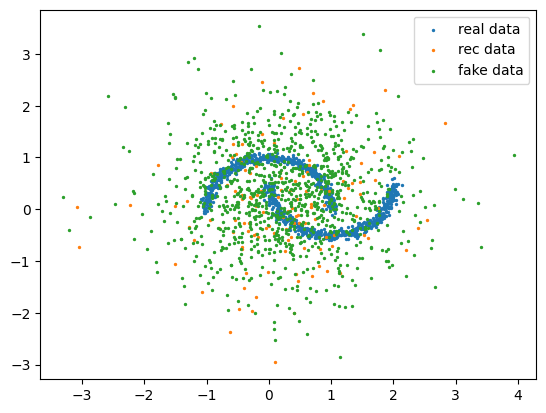

step 10000: KL: 1.258e+00, rec: -1.429e+00, total: -1.712e-01


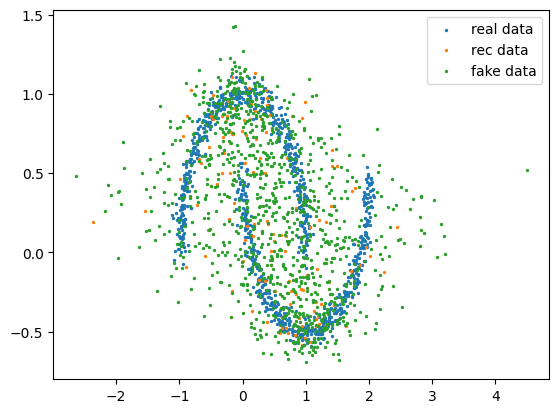

step 20000: KL: 1.311e+00, rec: -1.481e+00, total: -1.701e-01


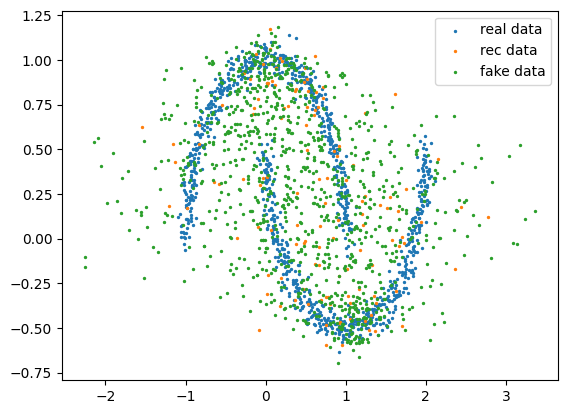

step 30000: KL: 1.328e+00, rec: -1.584e+00, total: -2.563e-01


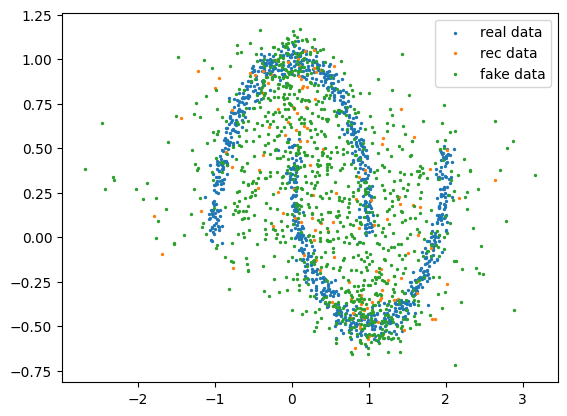

step 40000: KL: 1.341e+00, rec: -1.677e+00, total: -3.358e-01


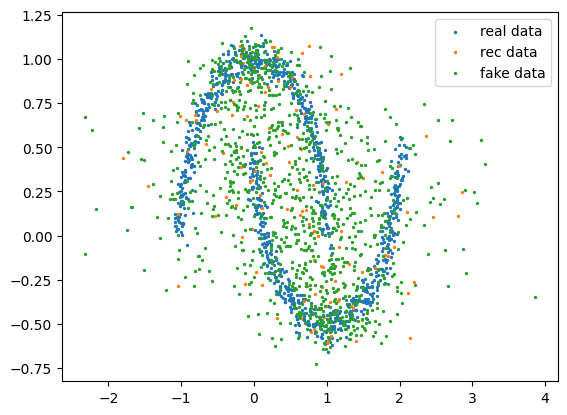

Training with latent sizes -encoder: 1000 -decoder: 10
step 0: KL: 4.503e+00, rec: 8.113e-01, total: 5.314e+00


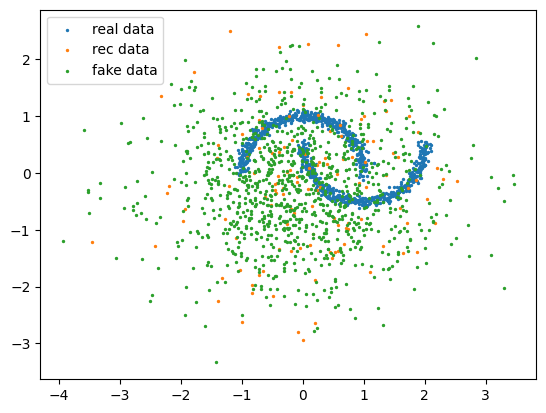

step 10000: KL: 1.650e+00, rec: -2.069e+00, total: -4.189e-01


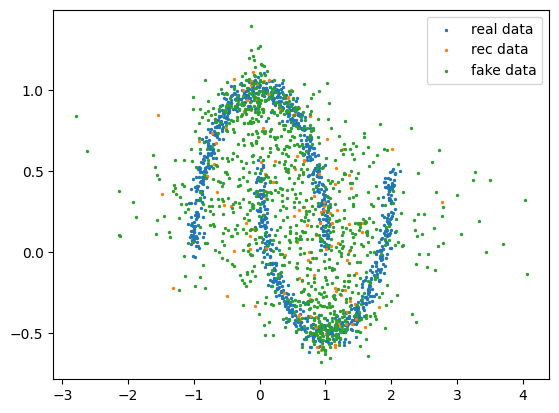

step 20000: KL: 1.591e+00, rec: -1.897e+00, total: -3.053e-01


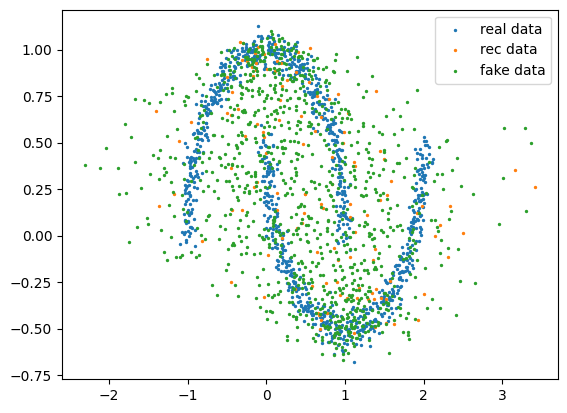

step 30000: KL: 1.654e+00, rec: -1.979e+00, total: -3.245e-01


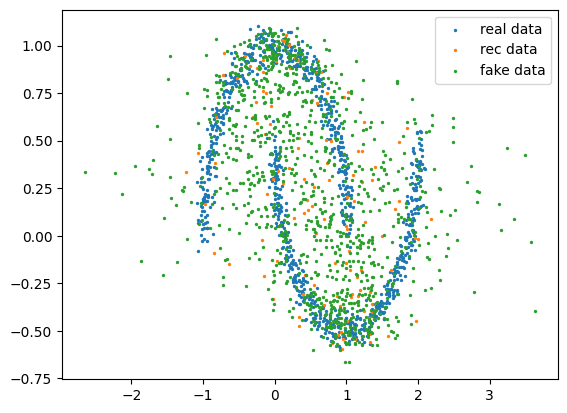

step 40000: KL: 1.654e+00, rec: -2.068e+00, total: -4.135e-01


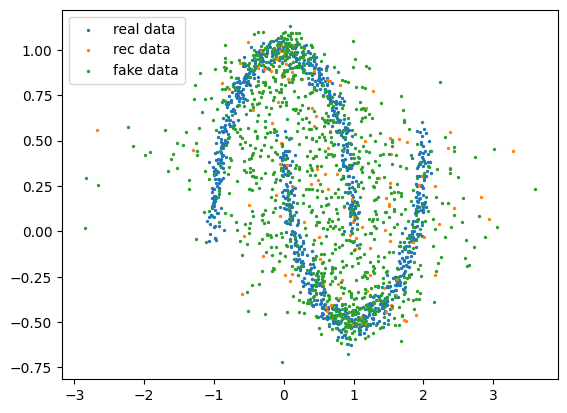

In [19]:
# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128
# Choose the dataset type
DATASET_TYPE = 'moons'  # 'checkerboard' or 'moons'
generate_selected_batch = lambda num_datapoints: generate_batching(num_datapoints, DATASET_TYPE)
N_LATENT = 30

N_SIZE = [(10, 1000), (1000, 10)]

for layer1, layer2 in N_SIZE:
    print('Training with latent sizes -encoder: {} -decoder: {}'.format(layer1, layer2))
    encoder = nEncoder(layer_dim=layer1)
    optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
    decoder = nDecoder(layer_dim=layer2)
    optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

    for i in range(N_ITER):
        encoder.zero_grad()
        decoder.zero_grad()

        x = generate_selected_batch(BATCHLEN)

        enc_mu, enc_logvar = encoder(x)
        #
        # COMPUTE THE KL PART OF THE LOSS HERE
        #
        loss_kl = 0.5*torch.sum(enc_mu**2 + torch.exp(enc_logvar) - enc_logvar - 1, dim=1)
        loss_kl = torch.mean(loss_kl)
        #
        # SAMPLE z FROM q(z|x) HERE
        #
        z = enc_mu + torch.exp(0.5*enc_logvar)*torch.normal(torch.zeros(BATCHLEN, LATENT_N), 1.0)

        dec_mu, dec_logvar = decoder(z)
        #
        # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
        #
        loss_rec = 0.5*torch.sum((x - dec_mu)**2 / torch.exp(dec_logvar) + dec_logvar, dim=1)
        loss_rec = torch.mean(loss_rec)

        (loss_kl + loss_rec).backward()
        optim_enc.step()
        optim_dec.step()
        if i%10000 == 0:
            print('step {}: KL: {:.3e}, rec: {:.3e}, total: {:.3e}'.format(i, float(loss_kl), float(loss_rec), float(loss_kl + loss_rec)))
            # plot the result
            real_batch = generate_selected_batch(1024)
            rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
            fake_batch = decoder.generate(1024).detach()
            plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
            plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
            plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
            plt.legend()
            plt.show()

Training with latent sizes -encoder: 505 -decoder: 505
step 0: KL: 4.492e+00, rec: 6.783e-01, total: 5.170e+00


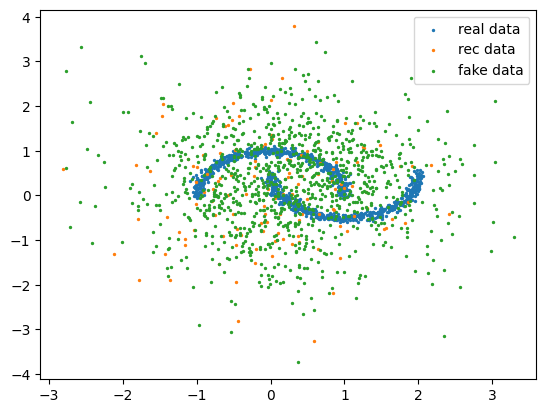

step 10000: KL: 1.444e+00, rec: -1.661e+00, total: -2.170e-01


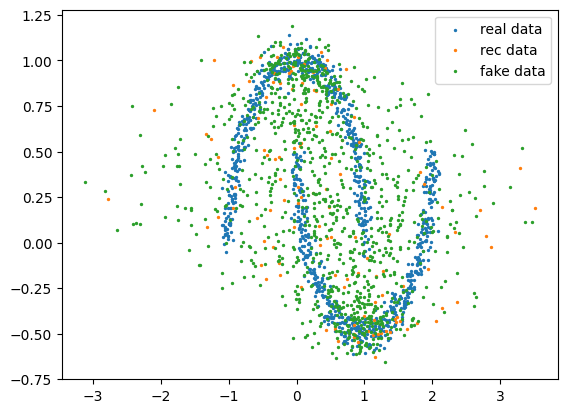

step 20000: KL: 1.500e+00, rec: -1.879e+00, total: -3.796e-01


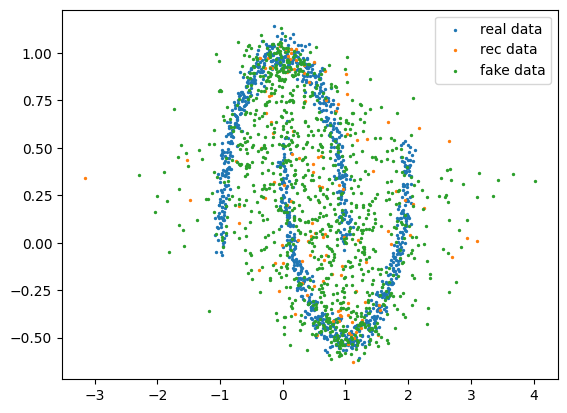

step 30000: KL: 1.595e+00, rec: -1.909e+00, total: -3.139e-01


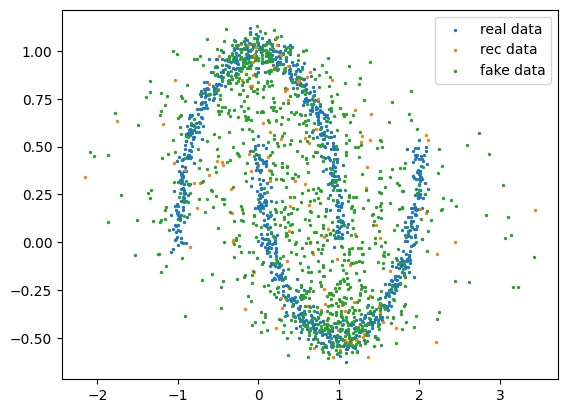

step 40000: KL: 1.575e+00, rec: -1.881e+00, total: -3.063e-01


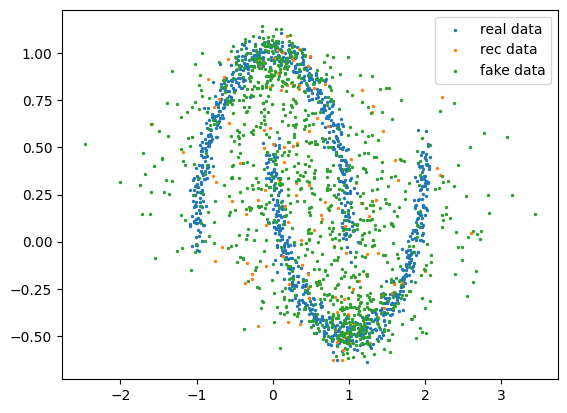

In [20]:
##############################################################################################################
############################################## Equilibrated architecture #####################################
##############################################################################################################

# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128
# Choose the dataset type
DATASET_TYPE = 'moons'  # 'checkerboard' or 'moons'
generate_selected_batch = lambda num_datapoints: generate_batching(num_datapoints, DATASET_TYPE)
N_LATENT = 30

N_SIZE = [(505, 505)]

for layer1, layer2 in N_SIZE:
    print('Training with latent sizes -encoder: {} -decoder: {}'.format(layer1, layer2))
    encoder = nEncoder(layer_dim=layer1)
    optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
    decoder = nDecoder(layer_dim=layer2)
    optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

    for i in range(N_ITER):
        encoder.zero_grad()
        decoder.zero_grad()

        x = generate_selected_batch(BATCHLEN)

        enc_mu, enc_logvar = encoder(x)
        #
        # COMPUTE THE KL PART OF THE LOSS HERE
        #
        loss_kl = 0.5*torch.sum(enc_mu**2 + torch.exp(enc_logvar) - enc_logvar - 1, dim=1)
        loss_kl = torch.mean(loss_kl)
        #
        # SAMPLE z FROM q(z|x) HERE
        #
        z = enc_mu + torch.exp(0.5*enc_logvar)*torch.normal(torch.zeros(BATCHLEN, LATENT_N), 1.0)

        dec_mu, dec_logvar = decoder(z)
        #
        # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
        #
        loss_rec = 0.5*torch.sum((x - dec_mu)**2 / torch.exp(dec_logvar) + dec_logvar, dim=1)
        loss_rec = torch.mean(loss_rec)

        (loss_kl + loss_rec).backward()
        optim_enc.step()
        optim_dec.step()
        if i%10000 == 0:
            print('step {}: KL: {:.3e}, rec: {:.3e}, total: {:.3e}'.format(i, float(loss_kl), float(loss_rec), float(loss_kl + loss_rec)))
            # plot the result
            real_batch = generate_selected_batch(1024)
            rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
            fake_batch = decoder.generate(1024).detach()
            plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
            plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
            plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
            plt.legend()
            plt.show()

> From the test we have conducted above, we cannot clearly state that the size difference between encoder and decoder has an important impact on the performance. It does appears that the model with equilibrated size has impressive performance but unequilibrated one too. 
<br><br>
> But we are conducing here some shallow test which cannot relate with much more complex situation. It is known that size difference in VAE can results in issues (not as big as GAN case). Indeed, an obvious statement first is that ultimately what we want to keep at the end of the training is the decoder (as a generator), this is not like the GAN where the discriminator is still usefull. Here the encoder part is pretty much useless after training (appart from more specific consideration such as data encoding). Thus, the decoder should never be too small. But an issue of having a decoder too big is that the decoder could try to generate the data by itself. Like it would try to fit the specific data distribution as if the encoded images were just a noisy dataset on which it was overfitting.
<br><br>
> In conclusion, the tradoff between both architecture size is not as much of a problem as in GAN case but it could still results in poorer generation. At least, one should not reduces the encoder size while thinking that it is completely useless.

---
## Flow Matching

Another approach to generative modeling is given by Normalizing flows. The idea is to learn a mapping $f$ from the data distribution $p_D$ (defined over a space $\mathcal{X}$) to a known distribution (typically, a normal distribution) from which we know how to sample. Two key points are to be noted:
1. The mapping needs to be bijective (i.e., the network needs to be invertible).
2. The exact likelihood of a data point should be easily computable.

For the implementation we will use Flow Matching, an approach for training Continuous Normalizing Flows based on regressing vector fields of fixed conditional probability paths.
Before diving into Flow Matching, let’s first clarify:

- A **vector field** is a mathematical object that assigns a vector to every point in a space. We can think of it as a function that describes the direction and speed of movement at every possible location.

- A **flow** is the trajectory that a point follows when it moves according to the directions given by the vector field over time. In general, data points evolve when guided by a vector field.


Let us denote $\renewcommand{\R}{\mathbb{R}} v : [0,1] \times \R^d \to \R^d $ a time-dependent vector field and $\phi : [0,1] \times \R^d \to \R^d$ a flow. A flow is related to a vector field $v_t$ as:
$$
\frac{d}{dt}\phi_t(x) = v_t(\phi_t(x))
$$
$$
\phi_0(x) = x
$$

The main idea of Flow Matching is to use a neural network to model the vector field $v_t$, which implies that $\phi_t$ will also be a parametric model simulating a Continuous Normalizing Flow (CNF). In the context of generative modeling, the CNF allows us to transform a simple prior distribution (e.g. Gaussian) $p_z$ into a more complex one $p_x$, which will be hopefully close enough to the data distribution $p_D$. To comply with the time-dependent framework, we assume a transition between $p_z$ and $p_x$ in a range $[0,1]$ so $p_z = p_0$ and $p_x = p_1$. We proceed by using the push-forward equation:
$$
p_t = [\phi_t]*p_0
$$
where $\forall x \in \R^2$:
$$
[\phi_t]*p_0(x) := p_0(\phi^{-1}(x)) \; \det\Big[ \frac{\delta \phi_t^{-1}}{\delta x} (x) \Big]
$$

So the flow $\phi$ acts as the mapping $f$ in this context. If you are not familiar with images of distributions, the definition is here: https://en.wikipedia.org/wiki/Pushforward_measure ; it can be defined as the measure that satisfies this change of variables: $\int_{z\sim p_\mathcal{N}} g(f^{-1}(z)) dz = \int_{x\sim p_{G}} g(x) dx$ for all functions $g$. Another notation for this is $\int_{z} g(f^{-1}(z)) \;dp_\mathcal{N}(z) = \int_{x} g(x) \;dp_{G}(x)$.

Thus Flow Matching aims to learn the true vector field $u_t$:
$$
L_{CFM}(\theta) = \mathbb{E}_{t,p_D(x_1),p_t(x|x_1)} || v_t(x) - u_t(x|x_1) ||^2
$$
> **Attention! Mind the difference in notation between the true vector $u$ and its estimation $v$.**

### Optimal Transport Conditional Vector Fields

We will use the simplest approach where the flow $\phi$ is a linear displacement.

Let $x_1 \sim p_D(x_1)$ be a point from the dataset. We can define the conditional flow $\psi_t$ (conditional version of $\phi_t$) to be the Optimal Transport displacement map between the two Gaussians $p_0(x|x_1)$ and $p_1(x|x_1)$, that is:
\begin{equation}
\psi_t(x) = (1 - (1 - \sigma_{min})t)x + tx_1
\end{equation}
(we can prove that $\psi_t$ satisfies the push-forward equation).

In the case of Optimal Transport conditional VFs the conditional flow matching objective loss can be written as follows:
$$
L_{CFM}(\theta) = \mathbb{E}_{t,p_D(x_1),p(x_0)} ||v_t(\psi_t(x_0)) - \frac{d}{dt}\psi_t(x_0)||^2
$$

**Q14: Express the derivative of $\psi_t(x_0)$, to simplify the formula of $L_{CFM}(\theta)$.**

> (Write your answer here)

**Q15: Calculate the determinant of the Jacobian of the flow $\phi_t(x)$.**

> (Write your answer here)

**Q16: Using the Jacobian determinant, prove that $\psi_t(x)$ is indeed invertible.**

> (Write your answer here)

**Q17: Prove that $\psi_t(x)$ satisfies the push-forward equation. That means that it applies scaling and shifting to the distribution $p_0(x)$.**

> (Write your answer here)

We sample $x_1 \sim p_D(x_1)$ (samples from the dataset), $x_0 \sim p(x_0)$ (samples from the prior distribution) and $t \sim \text{Unif}([0,1])$. We need to apply a little trick for time sampling since the batch covers the range $[0,1]$ uniformly with a random offset. Then we compute an approximation of the CFM Loss on the batch:
$$
L_{batch}(\theta) = \frac{1}{N} \sum_{i=0}^{N-1} ||v_t(\psi_t(x_0^{(i)})) - (x_1^{(i)} - (1 - \sigma_{min})x_0^{(i)})||^2
$$

**Q18: Fill the Coupling layer structure below by defining suitable functions sfun and tfun (using a final tanh in sfun is highly recommended) and the inverse pass**

In [ ]:
class OptimalTransportFlowMatching:
    def __init__(self, sig_min: float = 0.001) -> None:
        super().__init__()
        self.sig_min = sig_min
        self.eps = 1e-5

    def psi_t(self, x: torch.Tensor, x_1: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """ Conditional Flow
        """
        #
        # COMPUTE THE CONDITIONAL FLOW HERE
        #
        return None

    def loss(self, v_t: nn.Module, x_1: torch.Tensor) -> torch.Tensor:
        """ Compute loss
        """
        # t ~ Unif([0, 1])
        # the batch covers the range [0,1] uniformly with a random offset
        t = (torch.rand(1, device=x_1.device) + torch.arange(len(x_1), device=x_1.device) / len(x_1)) % (1 - self.eps)
        t = t[:, None].expand(x_1.shape) # turn 2d

        #
        # SAMPLE THE PRIOR DISTRIBUTION HERE
        # x_0 ~ p(x_0)
        #

        #
        # CALCULATE THE BATCH LOSS HERE
        #
        return None

### Conditional Vector Field

We add the Conditional Vector Field class which aims to model the Optimal Transport Conditional Vector Field $v_t$. This approximation $v_t(\cdot;\theta)$ of the true $v_t$ will be optimized by tuning the parameters $\theta$ of ConditionalVectorField.

Once optimized, we need to sample from the learned flow, thus we define the encode and decode functions:
- `encode` maps the data distribution $p_D(x_1) \approx p_1(x_1)$ to the prior distribution $p(x_0)$.
- `decode` maps the prior distribution $p(x_0)$ to the data distribution $p_1(x_1) \approx p_D(x_1)$.

A flow $\phi_t$ and its corresponding vector field $v_t$ verify the following equations:
$$
\frac{d}{d_t}\phi_t(x) = v_t(\phi_t(x))
$$
$$
\phi_0(x) = x
$$
Thus, to encode we integrate the first equation from $t=1$ to $t=0$ and the decode function is the same but going from $t=0$ to $t=1$.
We use the Euler method to encode and decode.

In [ ]:
class ConditionalVectorField(nn.Module):
    def __init__(self, net: nn.Module, n_steps: int = 100, dt: float = 0.01) -> None:
        super().__init__()
        self.net = net
        self.n_steps = n_steps
        self.dt = dt

    def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        return self.net(t, x)

    def wrapper(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        t = t * torch.ones(len(x), device=x.device)
        return self(t, x)

    def encode(self, x_1: torch.Tensor) -> torch.Tensor:
        x = x_1
        t = torch.ones(x.shape[0], device=x.device)  # Start from t=1
        for _ in range(self.n_steps):
            v = self.wrapper(t, x)
            x = x - self.dt * v  # Reverse Euler update
            t = t - self.dt  # Decrement time
        return x

    def decode(self, x_0: torch.Tensor) -> torch.Tensor:
        x = x_0
        t = torch.zeros(x.shape[0], device=x.device)
        for _ in range(self.n_steps):
            v = self.wrapper(t, x)
            x = x + self.dt * v # Euler update
            t = t + self.dt # Step increment
        return x

### Neural Network for VF approximation

We want to approximate $v_t$ with a parametric model $v_t(\cdot;\theta)$. Since we deal with point coordinates and want to keep the neural network simple for this example, we use a simple Multilayer Perceptron.

However the vector field $v$ is conditioned on time $t$. Thus, we create a sinusoidal positional encoding of $t$ thanks to sine and cosine functions to have a time representation that is easier to exploit than just its value between 0 and 1.

When computing $v_t(x)$ we simply concatenate the sinusoidal positional encoding of $t$ with $x$ (input coordinates), and then process the obtained tensor with the MLP's layers.

In [ ]:
class Net(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, h_dims: list[int], n_frequencies:int) -> None:
        super().__init__()
        ins = [in_dim + 2 * n_frequencies] + h_dims
        outs = h_dims + [out_dim]
        self.n_frequencies = n_frequencies

        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(in_d, out_d), nn.LeakyReLU()) for in_d, out_d in zip(ins, outs)
        ])
        self.top = nn.Sequential(nn.Linear(out_dim, out_dim))

    def time_encoder(self, t: torch.Tensor) -> torch.Tensor:
        freq = 2 * torch.arange(self.n_frequencies, device=t.device) * torch.pi
        t = freq * t[..., None]
        return torch.cat((t.cos(), t.sin()), dim=-1)

    def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        t = self.time_encoder(t)
        x = torch.cat((x, t), dim=-1)

        for l in self.layers:
            x = l(x)
        return self.top(x)

### Train

In [ ]:
# globals
BATCH_SIZE = 128
LOG_INTERVAL = 50
N_EPOCHS = 10
INPUT_SIZE = 2
OUTPUT_SIZE = 2
HIDDEN_SIZE = 256
N_LAYERS = 5
TIME_FREQUENCY = 10

In [ ]:
# data loading
train_data = generate_batch(50000)
test_data = generate_batch(1000)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
model = OptimalTransportFlowMatching()
net = Net(INPUT_SIZE, OUTPUT_SIZE, [HIDDEN_SIZE]*N_LAYERS, TIME_FREQUENCY).to(device)
v_t = ConditionalVectorField(net)

losses = []
# configure optimizer
optimizer = torch.optim.Adam(v_t.parameters(), lr=1e-3)
n_epochs = 5000

for epoch in range(N_EPOCHS):
    for batch_idx, x_inputs in enumerate(train_loader):
        x_1 = x_inputs.to(device)
        # compute loss
        loss = model.loss(v_t, x_1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses += [loss.detach()]
        if batch_idx % LOG_INTERVAL == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(x_inputs), len(train_data),
                100. * batch_idx / len(train_loader), loss / len(x_inputs)))


### Sampling

To sample $\hat{x}_1 \sim p_D(x_1)$, we first sample $x_0 \sim p(x)$, drawing samples from the prior distribution, and then apply the decode function from the ConditionalVectorField class.

In [ ]:
#
# SAMPLE THE PRIOR AND DECODE HERE
#

In [ ]:
#
# PLOT THE DENSITY HERE
#

**Q19: Explain why Normalizing flows do not fit well when there are many clusters in the data.**

> (Write your answer here)

---
## Denoising Diffusion Model

Recently Diffusion Models received a lot of attention. __Diffusion Models Beat GANs on Image Synthesis__ *(Dhariwal,Nichol)* : [arXiv:2105.05233](https://arxiv.org/pdf/2105.05233.pdf) shows significant improvement on image generation with a model claimed to be easier to train than GANs.


It is the key of the image generating process behind Latent Diffusion models such as Dall.e, Imagen or StableDiffusion.

We are going to implement a model inspired by the paper
__Denoising Diffusion Probabilistic Models__  *(Ho et al.)*: [arXiv:2006.11239](https://arxiv.org/pdf/2006.11239.pdf)


 Denoising diffusion probabilistic model  introduce noise into data and gradually learn to reverse this process for generating new samples. It involves two Markov chains, one that forwards data to noise, and another that reverses this process by converting the noise back to data. The forward chain is usually designed to transform any data distribution into a simpler prior distribution, such as a standard Gaussian distribution, while the reverse Markov chain is parametrized by a neural network and learns to reverse this process. To generate new data points, we first sample a random vector from the prior distribution, then applies ancestral sampling through the reverse Markov chain.

 References:

- Survey on Diffusion Models : https://arxiv.org/pdf/2209.00796.pdf
- https://lilianweng.github.io/posts/2021-07-11-diffusion-models/
- https://blog.alexalemi.com/diffusion.html
- https://sander.ai/posts/



![Denoisingdiagram](./illustrationDenoising.png)

$q$ and $p_{\theta}$ being the respective kernels of the two chains.


#### Forward Pass ####

For our purpose we are going to use a Gaussian Noise. The forward Kernel will have the following shape :

$$q(x_t| x_{t-1}) = \mathcal{N}(x_t;\sqrt{1- \beta_t} x_{t-1},\beta_t I )$$

with $\mathcal{N}(x;\mu,\sigma I )$ a conditional gaussian :
$$ y \sim \mathcal{N}(x;\mu,\sigma I ) \equiv y|x \sim  \mathcal{N}(\mu,\sigma I )$$

**Q20: What does $\beta_t$ represent in the formula ?**

> (Write your answer here)

In our example the sequence $\beta_t$ will be chosen linearly wrt $t$.

We introduce $\alpha_t := 1-\beta_t$ and $\overline{\alpha_t} = \prod_{s=1}^{t} \alpha_s$ we can sample forward directly at timestep $t$ from the original image :
$$q(\mathbf{x}_{1:T}|\mathbf{x}_0) = \prod_{t=1}^{T}q(\mathbf{x}_t|\mathbf{x}_{t-1})$$
$$ q(\mathbf{x}_t| \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t;\sqrt{\overline{\alpha_t}} \mathbf{x}_0, (1-\overline{\alpha_t})I)$$

i.e.
\begin{align}
\boldsymbol{x}_t = \sqrt{\bar{\alpha}_t} \boldsymbol{x}_0 + \sqrt{1 - \bar{\alpha}_t} \boldsymbol{\epsilon} \;\;\; \text{where} \; \boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
\end{align}

we will then fix $$\sigma_t = \sqrt{1 - \bar{\alpha}_t}$$

**Q22:  Implement the forward pass using $\overline{\alpha_t}$ (Hint : you may need to precalculate the $\overline{\alpha_t}$ from $\beta_t$)**

In [ ]:
def bcast_right(x: torch.Tensor, ndim: int) -> torch.Tensor:
    """Util function for broadcasting to the right."""
    if x.ndim > ndim:
        raise ValueError(f'Cannot broadcast a value with {x.ndim} dims to {ndim} dims.')
    elif x.ndim < ndim:
        difference = ndim - x.ndim
        return x.view(x.shape + (1,) * difference)
    else:
        return x


In [ ]:
class DiscreteDDPMProcess:
    """A Gaussian diffusion process: q(xt|x0) = N(sqrt_alpha_bar(t)*x0, sigma(t)^2 * I),
    which implies the following transition from x0 to xt:

    xt = sqrt_alpha_bar(t) x0 + sigma(t) eps, eps ~ N(0, I).

    Diffusion processes differ in how they specify sqrt_alpha_bar(t) and/or sigma(t).
    Here we follow the DDPM paper.

    """
    def __init__(
        self,
        num_diffusion_timesteps: int = 1000,
        beta_start: float = 0.0001,
        beta_end: float = 0.02,
    ):
        self._num_diffusion_timesteps = num_diffusion_timesteps
        self._beta_start = beta_start
        self._beta_end = beta_end
        self._betas = np.linspace(self._beta_start, self._beta_end, self._num_diffusion_timesteps)

        alphas_bar = self._get_alphas_bar()
        ###############
        # TO COMPLETE #
        ###############
        self._sqrt_alphas_bar = ? #put in dtype=torch.float32
        self._sigmas = ? #put in dtype=torch.float32

    @property
    def tmin(self):
        return 1

    @property
    def tmax(self):
        return self._num_diffusion_timesteps

    def _get_alphas_bar(self) -> np.ndarray:
        ###############
        # TO COMPLETE #
        ###############
        alphas_bar = ?

        # we can add this 1 in front to simplify indexing,
        # and to make alpha[0]=1 and sigma[0]=0.
        # these values at t=0 will be needed later when generating samples
        alphas_bar = np.concatenate(([1.], alphas_bar))

        return alphas_bar

    def sqrt_alpha_bar(self, t: torch.Tensor) -> torch.Tensor:
        return self._sqrt_alphas_bar[t.long()]

    def sigma(self, t: torch.Tensor) -> torch.Tensor:
        return self._sigmas[t.long()]

    def sample(self, x0: torch.Tensor, t: torch.Tensor, eps: torch.Tensor) -> torch.Tensor:
        """Draws samples from the forward diffusion process q(xt|x0)."""
        ###############
        # TO COMPLETE #
        ###############
        return

In [ ]:
# data loading
test_data = generate_batch(1000)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
process = DiscreteDDPMProcess(num_diffusion_timesteps=1000)
ts = torch.Tensor(np.linspace(process.tmin, process.tmax, num=process.tmax, dtype=np.int32))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(4 * 2, 2))

# plot how sqrt_alpha_bar and sigma change over time
ax[0].plot(ts.numpy(), process.sigma(ts), label=r'$\sigma$')
ax[0].plot(ts.numpy(), process.sqrt_alpha_bar(ts), label=r'$\sqrt{\bar\alpha}$')
ax[0].set_xlabel('time')
ax[0].legend()

# It is often helpful to reason in terms of signal-to-noise ratio:
# SNR = sqrt_alpha_bar(t)^2 / sigma(t)^2 or more conveniently, its logarithm.
# High SNR = little noise, low SNR = a lot of noise.
lambda_ = [2. * np.log(process.sqrt_alpha_bar(t) / process.sigma(t)) for t in ts]
ax[1].plot(ts.numpy(), lambda_, c='g', label=r'$log SNR$')
ax[1].set_xlabel('time')
ax[1].legend()

plt.show()

In [ ]:
# Effect on the distribution
torch_test_data = torch.Tensor(test_data)
def apply_on_dataset(dataset,t):
    dataset_t = torch.zeros_like(dataset)
    for i in range(dataset.shape[0]):
        point = dataset[i]
        eps = torch.randn_like(point)
        point_t = process.sample(point, t, eps)
        dataset_t[i] = point_t
    return dataset_t

fig,axes = plt.subplots(1,5,figsize=(20,5))
axes[0].scatter(torch_test_data[:,0],torch_test_data[:,1])
for i in range(1,5):
    t = torch.Tensor([i*50]).type(torch.int64)
    dataset_t = apply_on_dataset(torch_test_data,t)
    axes[i].scatter(dataset_t[:,0],dataset_t[:,1])
    axes[i].set_title(f"After {t.detach().item()} walks")
fig.suptitle("Influence of the forward pass on the distribution")
plt.show()



#### Backward Process

Hypothetically, We would like  to train the reverse kernel $p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)$, with parameters $\theta$ parametrized by a neural network

$$
p_\theta\left(\mathbf{x}_{0: T}\right):=p\left(\mathbf{x}_T\right) \prod_{t=1}^T p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)
$$

with $p(\mathbf{x}_T)$ a Gaussian prior, $p(\mathbf{x}_T) \sim \mathcal{N}(0,I)$ . We would use $p(\mathbf{x}_T)$ to sample new data points for generation.

#### Variational Lower Bound

In the paper, they used the knowledge of the forward pass and design a  Gaussian  reverse kernel

$$
p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)=\mathcal{N}\left(\mathbf{x}_{t-1} ; \mu_\theta\left(\mathbf{x}_t, t\right), \Sigma_\theta\left(\mathbf{x}_t, t\right)\right)
$$

with $\mu_{\theta}$ and $\Sigma_{\theta}$  parametrized by a neural network

We can write the previous forward kernel
$$
\begin{aligned}
q\left(\mathbf{x}_t \mid \mathbf{x}_0\right) & =\mathcal{N}\left(\mathbf{x}_t ; \sqrt{\bar{\alpha}_t} \mathbf{x}_0,\left(1-\bar{\alpha}_t\right) \mathbf{I}\right) \\
& =\sqrt{\bar{\alpha}_t} \mathbf{x}_0+\epsilon \sqrt{1-\bar{\alpha}_t}
\end{aligned}
$$
with $ \epsilon \sim \mathcal{N}(0, \mathbf{I})$

The natural loss would be to optimize under the variational lower bound $L_t$ such that :
$$
\begin{aligned}
L_{\mathrm{vlb}} & :=L_0+L_1+\ldots+L_{T-1}+L_T \\
L_0 & :=-\log p_\theta\left(x_0 \mid x_1\right) \\
L_{t-1} & :=D_{K L}\left(q\left(x_{t-1} \mid x_t, x_0\right) \| p_\theta\left(x_{t-1} \mid x_t\right)\right) \\
L_T & :=D_{K L}\left(q\left(x_T \mid x_0\right) \| p\left(x_T\right)\right)
\end{aligned}
$$

One can show that an alternative loss can be used that only take one parametrized estimator $\epsilon_{\theta}$. \
Hint: KL divergences between Gaussian distributions can be computed analytically
$$
L_{\text {simple }}(\theta):=\mathbb{E}_{t, \mathbf{x}_0, \boldsymbol{\epsilon}}\left[\left\|\boldsymbol{\epsilon}-\boldsymbol{\epsilon}_\theta\left(\sqrt{\bar{\alpha}_t} \mathbf{x}_0+\sqrt{1-\bar{\alpha}_t} \boldsymbol{\epsilon}, t\right)\right\|^2\right]
$$

Let's start implementing the network that predicts $\widehat \epsilon(x_t, t; \theta)$. Note that, as stated by its definition, $\epsilon$ is the cumulated noise from $t=0$ and not just the noise added at the last step.

In [ ]:
import torch.nn as nn

class ResidualMLP(nn.Module):
    """MLP with residual connections."""

    def __init__(
        self,
        n_blocks: int,
        n_hidden: int,
        n_out: int,
        activation: str,
        name: str = None
    ):
        super(ResidualMLP, self).__init__()
        self._n_blocks = n_blocks
        self._n_hidden = n_hidden
        self._n_out = n_out
        self._activation = getattr(nn.functional, activation)

        self.linear_input = nn.Linear(n_out, n_hidden)
        self.linear_time = nn.ModuleList([nn.Linear(n_hidden, n_hidden) for _ in range(self._n_blocks)])
        self.linear_hidden = nn.Sequential(
    nn.ModuleList([nn.Linear(n_hidden, n_hidden) for _ in range(self._n_blocks)]),
    nn.ModuleList([nn.Linear(n_hidden, n_hidden) for _ in range(self._n_blocks)])
        )
        self.linear_output = nn.Linear(n_hidden, n_out)

    def forward(self, xt: torch.Tensor, time: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(xt)

        for _ in range(self._n_blocks):
            h=self._activation(x)
            h=self.linear_hidden[_][0](h)
            h=h+self.linear_time[_](time)
            h=self._activation(h)
            h=self.linear_hidden[_][1](h)
            x=x+h

        outputs = self.linear_output(x)

        return outputs


#### Time embeddings

As we can see above, the denoiser network needs to get timestep $t$ as an input.

However, feeding integers $t=1, 2, ... T$ into the network will not work.

[Transformers](https://arxiv.org/abs/1706.03762), when faced with the same problem, proposed to embed timesteps into $d$-dimensional vectors of sinusoids:

$$e = [\; \sin(w_1 t) \; \; \cos(w_1 t) \; ... \; \sin(w_{d/2} t) \; \; \cos(w_{d/2} t) \;]$$

with $w_i = 1/ 10000^{\frac{2i}{d}}$.

Here is nice blogpost with more intuition: https://kazemnejad.com/blog/transformer_architecture_positional_encoding/


In [ ]:
class SinusoidalTimeEmbedding(nn.Module):
    """Time (positional) embedding as in Transformers."""

    def __init__(self, num_features: int, name: str = None):
        super(SinusoidalTimeEmbedding, self).__init__()
        self._num_features = num_features

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        assert len(inputs.shape) == 1
        half_dim = self._num_features // 2
        e = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        embedding = torch.exp(-e * torch.arange(half_dim).float()).to(device)
        embedding = inputs.view(-1, 1) * embedding
        embedding = torch.cat([torch.cos(embedding), torch.sin(embedding)], dim=-1)
        if self._num_features % 2 == 1:
            embedding = nn.functional.pad(embedding, (0, 1))
        return embedding


Now we need to put the two modules together:

In [ ]:
import dataclasses

@dataclasses.dataclass
class NetConfig:
    resnet_n_blocks: int = 2
    resnet_n_hidden: int = 256
    resnet_n_out: int = 2
    activation: str = 'elu'
    time_embedding_dim: int = 256


class Net(nn.Module):
    """Combines MLP and time embeddings."""
    def __init__(self, net_config: NetConfig, name: str = None):
        super(Net, self).__init__()

        self._time_encoder = SinusoidalTimeEmbedding(net_config.time_embedding_dim)
        self._predictor = ResidualMLP(
            n_blocks=net_config.resnet_n_blocks,
            n_hidden=net_config.resnet_n_hidden,
            n_out=net_config.resnet_n_out,
            activation=net_config.activation
        )

    def forward(self, noisy_data: torch.Tensor, time: torch.Tensor) -> torch.Tensor:
        time_embedding = self._time_encoder(time)
        outputs = self._predictor(noisy_data, time_embedding)
        return outputs


#### Time sampler

To compute our loss function, for each example, we need to sample a random timestep. In this trivial case of uniform sampling between step 1 and T, it might be an overkill to implement it as a separate class. It would be more helpful if you're going to explore more exotic diffusion models.

In [ ]:
from typing import Sequence

class UniformDiscreteTimeSampler:

    def __init__(self, tmin: int, tmax: int):
        self._tmin = tmin
        self._tmax = tmax

    def sample(self, shape: Sequence[int]) -> torch.Tensor:
        return torch.randint(low=self._tmin, high=self._tmax, size=shape)


#### Full DDPM model

**Q.23 Implement the Simplified loss given a model $\epsilon_{\theta}$**

In [ ]:
class DiffusionModel(nn.Module):
    """Diffusion model."""

    def __init__(self, diffusion_process, time_sampler, net_config, data_shape):
        super(DiffusionModel, self).__init__()

        self._process = diffusion_process
        self._time_sampler = time_sampler
        self._net_config = net_config
        self._data_shape = data_shape
        self.net_fwd = Net(net_config)

    def loss(self, x0: torch.Tensor) -> torch.Tensor:
        """Computes MSE between the true noise and predicted noise,
        i.e. the goal of the network is to correctly predict eps from a noisy observation
        xt = alpha(t) * x0 + sigma(t)**2 * eps"""

        ###############
        # TO COMPLETE #
        ###############

        t = ?  # sample time

        eps = ?  # sample noise

        xt = ?  # corrupt the data

        net_outputs = ?  # get net outputs

        loss = ?  # compute MSE loss between predicted and true noise

        return loss

    #Used for sampling
    def _reverse_process_step(
        self,
        xt: torch.Tensor,
        t: int,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Computes parameters of a Gaussian p_{\theta}(x_{t-1}| x_t)."""

        t = t * torch.ones((xt.shape[0],), dtype=torch.int32, device=xt.device)

        ###############
        # TO COMPLETE #
        ###############

        eps_pred = ?  # predict epsilon from x_t

        sqrt_alpha_t = ? # use self._sqrt_alpha_bar
        inv_sqrt_alpha_t = bcast_right(1.0 / sqrt_alpha_t, xt.ndim)

        beta_t = ?
        beta_t = bcast_right(beta_t, xt.ndim)

        inv_sigma_t = ?
        inv_sigma_t = bcast_right(inv_sigma_t, xt.ndim)

        mean = ?

        # DDPM instructs to use either the variance of the forward process
        # or the variance of q(x_{t-1}|x_t, x_0). Former is easier.
        std = ?

        eps = ?

        return ?


    def sample(self, x0, sample_size):
    """To generate samples from DDPM, we follow the reverse process.
    At each step of the chain, we sample x_{t-1} from p(x_{t-1}| x_t, x0_pred) until we get to x_0."""
        with torch.no_grad():
            x = torch.randn((sample_size,) + self._data_shape, device=x0.device) #sample pure noise


            ###############
            # TO COMPLETE #
            ###############

        return x

Given the noise obtained by the model $\boldsymbol{\epsilon}_\theta\left(\mathbf{x}_t, t\right)$, you can sample $\mu_{\theta}(\mathbf{x}_t,t)$ in order to get a denoised sample point.
$$
\mu_{\theta}(\mathbf{x}_t,t) = \frac{1}{\sqrt{\alpha_t}}\left(\mathbf{x}_t-\frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \boldsymbol{\epsilon}_\theta\left(\mathbf{x}_t, t\right)\right)
$$


The _reverse_process_step function sample $x_{t-1} \sim p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)$ where
$$
p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)=\mathcal{N}\left(\mathbf{x}_{t-1} ; \mu_\theta\left(\mathbf{x}_t, t\right), \Sigma_\theta\left(\mathbf{x}_t, t\right)\right)
$$
and we set $$\Sigma_\theta\left(\mathbf{x}_t, t\right) = \beta_{t}\boldsymbol{I}$$

Thus $$x_{t-1} = \mu_{\theta}(\mathbf{x}_t,t) + \sqrt{\beta_t}\epsilon$$ where $$\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$$

**Q.24 Build the sampling function that allows you from inputs $\mathbf{x}_t$ and $t$ to obtain $\mu_{\theta}(\mathbf{x}_t,t)$ and $x_{t-1}$**

#### Training

In [ ]:
from torch import optim

# create the model
diffusion_process = DiscreteDDPMProcess(num_diffusion_timesteps=1000)
time_sampler = UniformDiscreteTimeSampler(diffusion_process.tmin, diffusion_process.tmax)
model = DiffusionModel(diffusion_process, time_sampler, net_config=NetConfig(), data_shape=(2,)).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

We will use a learning rate scheduler with a warmup. \
You will have to install the library pytorch_warmup with "pip install -U pytorch_warmup": https://github.com/Tony-Y/pytorch_warmup \
Our learning rate schedule will have the following shape.

![Denoisingdiagram](./lr_with_warmup.png)

In [ ]:
import pytorch_warmup as warmup

training_steps = 50000

warmup_period=1000 #this is the increasing part of the learning rate schedule
num_steps = training_steps
t0 = num_steps // 1
lr_min = 3e-12
max_step = t0 * 1 + warmup_period #you can also create cycle but we won't touch it here

lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=t0, T_mult=1, eta_min=lr_min)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)


##### Training loop

**Q.25 Train $\epsilon_{\theta}(\mathbf{x},t)$ that take as entry a transformed vector $\mathbf{x}$ and  $t$ a number of time $\mathbf{x}$ passed through the forward process  and return  a direct estimate of  the noise $\epsilon$**

In [ ]:
BATCH_SIZE=1024

for step in range(training_steps):
    #generate batch on the fly

    ###############
    # TO COMPLETE #
    ###############

    if step % 1000 == 0:
        print(f'Step: {step}, Loss: {loss:.5f}')

    if step % 10000 == 0:
        with torch.no_grad():
            samples = ? # create new samples
        plt.figure(figsize=(3, 3))
        plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.5)
        plt.show()

    with warmup_scheduler.dampening():
        if warmup_scheduler.last_step + 1 >= warmup_period:
            lr_scheduler.step()
        if warmup_scheduler.last_step + 1 >= max_step:
            break


#### Ablation study

**Q.26 Perform ablations experiments on hyperparameters, such as: learning rate (try constant learning rate with different values), batch size, the number of timesteps, the positional embedding for timestep (remove it), the hidden size, number of epochs, skip connections**

For a given ablation experiment (they ought to be done separately!), you should plot generated samples at few given timesteps (if compute resources is limited, do it for one timestep).

Note: you don't have to do all of these experiments, but the bigger is your group, the more you should do.

> (Write your answer here)

#### Generation/Sampling

**Q.27  Generate samples and plot them at different timestep of the chain. Check how real & synthetic distribution overlap, compare the densities**

---
## Conclusion

**Q.28: As a conclusion, how would you compare the advantages and shortcomings of GANs, VAEs, Flow Matching and Denoising Models ?**

> Let us do a brief recap on advantages and shortcomings of those four methods :
<br><br>
> - GANs:
<br>
>   - Advantages : GANs methods allow us to train a generator at the same time than training a discriminator. This is quite usefull for task like "IA test", verifying wether something is generated by a model or not. It also allow us to bypass many of the density issues because we do not need to make some specific choice on prior density or to follow the data distribution. Ultimately, it can even be used to produce higher quality images.
<br>
>   - Shortcommings : GANs are generally less stable than other methods. Indeed, they are highly dependant of hyperparameters tuning. And the balance between models sizes is hard to find.
<br>
> - VAEs:
<br>
>   - Advantages : VAEs is a more robust method to fit a data distribution. It is somehow regularized in order to give more realistic results using the prior law. The computation process is also easier and quicker with more flexibility on hyperparameters. It is also a bit more explainable as one compute an approximated distribution using such a method.
<br>
>   - Shortcommings : VAEs have a harder time approximating complex distribution that can difficultly be fitted by multivariate gaussian. For example, inhomogenous data distribution with highly non-continuous features would results in interpolated law for the decoder yielding very poor results. It also produce lower quality resolution for images with respect to similar model size.
<br>
> - Flow Matching:
<br>
>   - Advantages : Flow matching methods are efficient and stable during training for similar reason than the VAE case. Indeed, the loss computation is much more stable (mismatch normed loss which is smoother). The method is also more flexible in the way to perform it, which can help align it with specific preferences for a given task. 
<br>
>   - Shortcommings : Flow matching is a much harder theoretical process than the others, which could make it more difficult to implement for many people in specific cases. There is also a tradoff induced by the integration process between computation time and precision.
<br>
> - Denoising Models:
<br>
>   - Advantages : Denoising method is one of the most robust. It avoid many issues induced by distribution reconstruction. The method is also more flexible to use in its already trained form (understand here that one can choose between time computation or quality with the number of inference). It is also highly compatible with constraint based method which allow for more complex and accurate model design (for example one can use a CLIP model to constrain generation on what they do not want to see produced by the model). Finally, in its latent form, diffusion model can be trained much more quickly than other methods.
<br>
>   - Shortcommings : Denoising models are often much more computationally expensive in order to generate data (because at the end you still have to process all the layers with multiple inferences). It is also an issue that during the training both bacward and upward process need to be stocked directly in the RAM. In general, denoising models require higher RAM space.
<br><br>
<br>
>**In conclusion**, it appears that each models has advantages compared to others, thus the question of which models to use for generation is less easily answered than one could expect. VAE models with GANs were the first method to be introduced but they are less and less used nowadays. It is mostly because latent diffusion has become the state-of-the-art model for image generation. Indeed, such a process as shown so much better results in this specific task than people begin to use it more generally for generation task. In fact, the untold truth behind those high performances could be that denoising method is very flexible and can be planned using much more complex kind of architecture (like Stable Diffusion which use U-NET layer). Thus, many contributions made so far in deep learning (and architecture design) could be used in denoising models. This is less the cases for other methods. Lastly, flow matching is more recent and less developped method. It is obviously hindered by its theoretical complexity which make it less applicable for many cases and persons but could still prove to be an efficient method in the futur thanks to it having less shortcommings.
<br>